## Initial settings (authorize, connect GD, install packages, etc)

In [ ]:
# @title get GEE authorization
import ee

# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-scai62')

In [ ]:
# @title Connect to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/NIFA_Download/ML_train/' .

In [ ]:
# @title Install necessary packages
!pip install folium
!pip install geopandas
!pip install netCDF4
!pip install --upgrade xee
!pip install rasterio
!pip install ipywidgets
!pip install permetrics==2.0.0

In [ ]:
# @title Import packages
import folium
from folium import Figure
import geopandas as gpd
import json
import geemap
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import netCDF4 as nc
import xarray
import rasterio
import math
import time
import os
from datetime import datetime, timedelta
import joblib
import ipywidgets as widgets
from IPython.display import display
from permetrics import RegressionMetric

## Read sites information and visualize

In [ ]:
# @title Read csv file: points id with coordinates
df_sites = pd.read_csv('./ML_train/ML_trainning_sites.csv')
df_sites

,ID,network,Latitude,Longitude,id_num,Lambda,Fmax,twi,rockDth,GWD
0,SCAN_Everglades_Ars,SCAN,25.500000,-80.550000,1,19.627060,0.580000,21.989756,14.136606,1.403830e+02
1,SCAN_Little_River,SCAN,31.500000,-83.550000,2,9.361156,0.500000,9.169703,9999.000000,1.770047e+02
2,SCAN_Powder_Mill,SCAN,39.017000,-76.850000,3,9.043694,0.297521,8.724751,107.666664,9.155414e+00
3,SCAN_Geneva_#1,SCAN,42.883000,-77.033000,4,8.853159,0.371901,8.567324,76.000000,7.095445e+02
4,SCAN_Eastview_Farm,SCAN,35.133000,-86.183000,5,9.835436,0.371901,9.446318,61.000000,1.719692e+03
...,...,...,...,...,...,...,...,...,...,...
592,ZMK,NC,39.338249,-91.226189,1027,9.962784,0.355372,10.766054,36.156742,2.655070e+02
593,ZSB,NC,40.282836,-93.913678,1030,10.701079,0.504132,9.084775,19.827314,4.455635e+02
594,ZTP,NC,42.761824,-88.538605,1054,9.749352,0.347107,10.380211,72.097214,5.684342e-12
595,ZXC,NC,34.775208,-79.229836,1151,10.553182,0.446281,10.465976,117.000000,5.767910e+02


In [ ]:
# @title Define feature collection: points ID, longitude, and latitude
lons_sub = ee.List(df_sites['Longitude'].tolist())
lats_sub = ee.List(df_sites['Latitude'].tolist())
idnum_sub = ee.List(df_sites['id_num'].tolist())
points = lons_sub.zip(lats_sub).zip(idnum_sub).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection = ee.FeatureCollection(points)

In [ ]:
# @title Visualization - spatial distribution of sites
import folium
from folium import Figure

fig = Figure(width=800, height=600)
m = folium.Map(location=[42, -95.25], zoom_start=4)


roi_geojson = feature_collection.getInfo()
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Satellite',
    overlay=True
).add_to(m)
folium.GeoJson(roi_geojson).add_to(m)

fig.add_child(m)

## Read ee.images (constant images)

In [ ]:
# @title Constant images
# DEM
dem = ee.Terrain.products(ee.Image("USGS/3DEP/10m"))

# Landcover
LC = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD').filterDate('2016-01-01', '2022-12-31').select('landcover').first()
# print(LC);

#polaris
bd_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_0_5').first().rename('bd_0_5')
# print(bd_0_5);
bd_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_5_15').first().rename('bd_5_15')
# print(bd_5_15);
bd_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_15_30').first().rename('bd_15_30')
bd_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_30_60').first().rename('bd_30_60')
bd_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_60_100').first().rename('bd_60_100')
bd_0_100 = bd_0_5.multiply(0.05).add(bd_5_15.multiply(0.1)).add(bd_15_30.multiply(0.15)).add(bd_30_60.multiply(0.3)).add(bd_60_100.multiply(0.4)).rename('bd_0_100')

clay_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_0_5').first().rename('clay_0_5')
clay_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_5_15').first().rename('clay_5_15')
clay_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_15_30').first().rename('clay_15_30')
clay_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_30_60').first().rename('clay_30_60')
clay_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_60_100').first().rename('clay_60_100')
clay_0_100 = clay_0_5.multiply(0.05).add(clay_5_15.multiply(0.1)).add(clay_15_30.multiply(0.15)).add(clay_30_60.multiply(0.3)).add(clay_60_100.multiply(0.4)).rename('clay_0_100')

ksat_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_0_5').first().rename('ksat_0_5')
ksat_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_5_15').first().rename('ksat_5_15')
ksat_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_15_30').first().rename('ksat_15_30')
ksat_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_30_60').first().rename('ksat_30_60')
ksat_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_60_100').first().rename('ksat_60_100')
ksat_0_100 = ksat_0_5.multiply(0.05).add(ksat_5_15.multiply(0.1)).add(ksat_15_30.multiply(0.15)).add(ksat_30_60.multiply(0.3)).add(ksat_60_100.multiply(0.4)).rename('ksat_0_100')

n_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_0_5').first().rename('n_0_5')
n_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_5_15').first().rename('n_5_15')
n_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_15_30').first().rename('n_15_30')
n_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_30_60').first().rename('n_30_60')
n_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_60_100').first().rename('n_60_100')
n_0_100 = n_0_5.multiply(0.05).add(n_5_15.multiply(0.1)).add(n_15_30.multiply(0.15)).add(n_30_60.multiply(0.3)).add(n_60_100.multiply(0.4)).rename('n_0_100')

sand_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_0_5').first().rename('sand_0_5')
sand_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_5_15').first().rename('sand_5_15')
sand_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_15_30').first().rename('sand_15_30')
sand_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_30_60').first().rename('sand_30_60')
sand_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_60_100').first().rename('sand_60_100')
sand_0_100 = sand_0_5.multiply(0.05).add(sand_5_15.multiply(0.1)).add(sand_15_30.multiply(0.15)).add(sand_30_60.multiply(0.3)).add(sand_60_100.multiply(0.4)).rename('sand_0_100')

silt_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_0_5').first().rename('silt_0_5')
silt_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_5_15').first().rename('silt_5_15')
silt_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_15_30').first().rename('silt_15_30')
silt_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_30_60').first().rename('silt_30_60')
silt_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_60_100').first().rename('silt_60_100')
silt_0_100 = silt_0_5.multiply(0.05).add(silt_5_15.multiply(0.1)).add(silt_15_30.multiply(0.15)).add(silt_30_60.multiply(0.3)).add(silt_60_100.multiply(0.4)).rename('silt_0_100')

theta_r_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_0_5').first().rename('theta_r_0_5')
theta_r_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_5_15').first().rename('theta_r_5_15')
theta_r_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_15_30').first().rename('theta_r_15_30')
theta_r_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_30_60').first().rename('theta_r_30_60')
theta_r_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_60_100').first().rename('theta_r_60_100')
theta_r_0_100 = theta_r_0_5.multiply(0.05).add(theta_r_5_15.multiply(0.1)).add(theta_r_15_30.multiply(0.15)).add(theta_r_30_60.multiply(0.3)).add(theta_r_60_100.multiply(0.4)).rename('theta_r_0_100')

theta_s_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_0_5').first().rename('theta_s_0_5')
theta_s_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_5_15').first().rename('theta_s_5_15')
theta_s_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_15_30').first().rename('theta_s_15_30')
theta_s_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_30_60').first().rename('theta_s_30_60')
theta_s_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_60_100').first().rename('theta_s_60_100')
theta_s_0_100 = theta_s_0_5.multiply(0.05).add(theta_s_5_15.multiply(0.1)).add(theta_s_15_30.multiply(0.15)).add(theta_s_30_60.multiply(0.3)).add(theta_s_60_100.multiply(0.4)).rename('theta_s_0_100')

alpha_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_0_5').first().rename('alpha_0_5')
alpha_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_5_15').first().rename('alpha_5_15')
alpha_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_15_30').first().rename('alpha_15_30')
alpha_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_30_60').first().rename('alpha_30_60')
alpha_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_60_100').first().rename('alpha_60_100')
alpha_0_100 = alpha_0_5.multiply(0.05).add(alpha_5_15.multiply(0.1)).add(alpha_15_30.multiply(0.15)).add(alpha_30_60.multiply(0.3)).add(alpha_60_100.multiply(0.4)).rename('alpha_0_100')

polaris = bd_0_5.addBands(bd_5_15).addBands(bd_15_30).addBands(bd_30_60).addBands(bd_60_100).addBands(bd_0_100)\
          .addBands(clay_0_5).addBands(clay_5_15).addBands(clay_15_30).addBands(clay_30_60).addBands(clay_60_100).addBands(clay_0_100)\
          .addBands(ksat_0_5).addBands(ksat_5_15).addBands(ksat_15_30).addBands(ksat_30_60).addBands(ksat_60_100).addBands(ksat_0_100)\
          .addBands(n_0_5).addBands(n_5_15).addBands(n_15_30).addBands(n_30_60).addBands(n_60_100).addBands(n_0_100)\
          .addBands(sand_0_5).addBands(sand_5_15).addBands(sand_15_30).addBands(sand_30_60).addBands(sand_60_100).addBands(sand_0_100)\
          .addBands(silt_0_5).addBands(silt_5_15).addBands(silt_15_30).addBands(silt_30_60).addBands(silt_60_100).addBands(silt_0_100)\
          .addBands(theta_r_0_5).addBands(theta_r_5_15).addBands(theta_r_15_30).addBands(theta_r_30_60).addBands(theta_r_60_100).addBands(theta_r_0_100)\
          .addBands(theta_s_0_5).addBands(theta_s_5_15).addBands(theta_s_15_30).addBands(theta_s_30_60).addBands(theta_s_60_100).addBands(theta_s_0_100)\
          .addBands(alpha_0_5).addBands(alpha_5_15).addBands(alpha_15_30).addBands(alpha_30_60).addBands(alpha_60_100).addBands(alpha_0_100)


In [ ]:
# @title Extract values from constant images using feature collection

# extract pixel values of DEM using feature collection
dem_values = dem.sampleRegions(collection=feature_collection,scale=100)
# print(dem_values.getInfo())
elevation_arr = np.array(dem_values.aggregate_array('elevation').getInfo())[:]
aspect_arr = np.array(dem_values.aggregate_array('aspect').getInfo())[:]
hillshade_arr = np.array(dem_values.aggregate_array('hillshade').getInfo())[:]
slope_arr = np.array(dem_values.aggregate_array('slope').getInfo())[:]
dem_idnum_arr = np.array(dem_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of LC using feature collection
LC_values = LC.sampleRegions(collection=feature_collection,scale=100)
landcover_arr = np.array(LC_values.aggregate_array('landcover').getInfo())[:]
LC_idnum_arr = np.array(LC_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of Polaris soil using feature collection
polaris_values = polaris.sampleRegions(collection=feature_collection,scale=100)
ml_sand_0_5 = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
ml_sand_0_100 = np.array(polaris_values.aggregate_array('sand_0_100').getInfo())[:]
ml_clay_0_5 = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
ml_clay_0_100 = np.array(polaris_values.aggregate_array('clay_0_100').getInfo())[:]
ml_bd_0_5 = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
ml_bd_0_100 = np.array(polaris_values.aggregate_array('bd_0_100').getInfo())[:]
ml_ksat_0_5 = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
ml_ksat_0_100 = np.array(polaris_values.aggregate_array('ksat_0_100').getInfo())[:]

#clay
clay_0_5_arr = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
clay_5_15_arr = np.array(polaris_values.aggregate_array('clay_5_15').getInfo())[:]
clay_15_30_arr = np.array(polaris_values.aggregate_array('clay_15_30').getInfo())[:]
clay_30_60_arr = np.array(polaris_values.aggregate_array('clay_30_60').getInfo())[:]
clay_60_100_arr = np.array(polaris_values.aggregate_array('clay_60_100').getInfo())[:]
#sand
sand_0_5_arr = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
sand_5_15_arr = np.array(polaris_values.aggregate_array('sand_5_15').getInfo())[:]
sand_15_30_arr = np.array(polaris_values.aggregate_array('sand_15_30').getInfo())[:]
sand_30_60_arr = np.array(polaris_values.aggregate_array('sand_30_60').getInfo())[:]
sand_60_100_arr = np.array(polaris_values.aggregate_array('sand_60_100').getInfo())[:]
#silt
silt_0_5_arr = np.array(polaris_values.aggregate_array('silt_0_5').getInfo())[:]
silt_5_15_arr = np.array(polaris_values.aggregate_array('silt_5_15').getInfo())[:]
silt_15_30_arr = np.array(polaris_values.aggregate_array('silt_15_30').getInfo())[:]
silt_30_60_arr = np.array(polaris_values.aggregate_array('silt_30_60').getInfo())[:]
silt_60_100_arr = np.array(polaris_values.aggregate_array('silt_60_100').getInfo())[:]
#theta_s
theta_s_0_5_arr = np.array(polaris_values.aggregate_array('theta_s_0_5').getInfo())[:]
theta_s_5_15_arr = np.array(polaris_values.aggregate_array('theta_s_5_15').getInfo())[:]
theta_s_15_30_arr = np.array(polaris_values.aggregate_array('theta_s_15_30').getInfo())[:]
theta_s_30_60_arr = np.array(polaris_values.aggregate_array('theta_s_30_60').getInfo())[:]
theta_s_60_100_arr = np.array(polaris_values.aggregate_array('theta_s_60_100').getInfo())[:]
#theta_r
theta_r_0_5_arr = np.array(polaris_values.aggregate_array('theta_r_0_5').getInfo())[:]
theta_r_5_15_arr = np.array(polaris_values.aggregate_array('theta_r_5_15').getInfo())[:]
theta_r_15_30_arr = np.array(polaris_values.aggregate_array('theta_r_15_30').getInfo())[:]
theta_r_30_60_arr = np.array(polaris_values.aggregate_array('theta_r_30_60').getInfo())[:]
theta_r_60_100_arr = np.array(polaris_values.aggregate_array('theta_r_60_100').getInfo())[:]
#bd
bd_0_5_arr = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
bd_5_15_arr = np.array(polaris_values.aggregate_array('bd_5_15').getInfo())[:]
bd_15_30_arr = np.array(polaris_values.aggregate_array('bd_15_30').getInfo())[:]
bd_30_60_arr = np.array(polaris_values.aggregate_array('bd_30_60').getInfo())[:]
bd_60_100_arr = np.array(polaris_values.aggregate_array('bd_60_100').getInfo())[:]
#n
n_0_5_arr = np.array(polaris_values.aggregate_array('n_0_5').getInfo())[:]
n_5_15_arr = np.array(polaris_values.aggregate_array('n_5_15').getInfo())[:]
n_15_30_arr = np.array(polaris_values.aggregate_array('n_15_30').getInfo())[:]
n_30_60_arr = np.array(polaris_values.aggregate_array('n_30_60').getInfo())[:]
n_60_100_arr = np.array(polaris_values.aggregate_array('n_60_100').getInfo())[:]
#alpha
alpha_0_5_arr = np.array(polaris_values.aggregate_array('alpha_0_5').getInfo())[:]
alpha_5_15_arr = np.array(polaris_values.aggregate_array('alpha_5_15').getInfo())[:]
alpha_15_30_arr = np.array(polaris_values.aggregate_array('alpha_15_30').getInfo())[:]
alpha_30_60_arr = np.array(polaris_values.aggregate_array('alpha_30_60').getInfo())[:]
alpha_60_100_arr = np.array(polaris_values.aggregate_array('alpha_60_100').getInfo())[:]
#ksat
ksat_0_5_arr = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
ksat_5_15_arr = np.array(polaris_values.aggregate_array('ksat_5_15').getInfo())[:]
ksat_15_30_arr = np.array(polaris_values.aggregate_array('ksat_15_30').getInfo())[:]
ksat_30_60_arr = np.array(polaris_values.aggregate_array('ksat_30_60').getInfo())[:]
ksat_60_100_arr = np.array(polaris_values.aggregate_array('ksat_60_100').getInfo())[:]

polaris_idnum_arr = np.array(polaris_values.aggregate_array('id_num').getInfo())[:]


In [ ]:
# @title Convert units of soil properties for ML inputs
ml_sand_0_5 = ml_sand_0_5 * 0.01   # convert to numerical
ml_sand_0_100 = ml_sand_0_100 * 0.01
ml_clay_0_5 = ml_clay_0_5 * 0.01
ml_clay_0_100 = ml_clay_0_100 * 0.01

ml_ksat_0_5 = np.power(10, ml_ksat_0_5)  # convert to cm/hr
ml_ksat_0_100 = np.power(10, ml_ksat_0_100)

## Add constant image values to dataframe and refine sites

In [ ]:
# @title Define extract_points_data function: extract raster values using cooradates
import osgeo.gdal as gdal
# extract values from image
def extract_points_data(file, lats, lons, undef=-9999.0):
    # Open file and get geotransformation
    ds = gdal.Open(file)
    gt = ds.GetGeoTransform()
    rb = ds.GetRasterBand(1)
    nx = ds.RasterXSize
    ny = ds.RasterYSize

    # Compute ilats and ilons
    ilons = np.round((np.array(lons) - (gt[0] + gt[1] / 2)) / gt[1]).astype(int)
    ilats = np.round((np.array(lats) - (gt[3] + gt[5] / 2)) / gt[5]).astype(int)

    # Extract data
    values = []
    for i in range(ilons.size):
        ilon = int(ilons[i])
        ilat = int(ilats[i])
        if ((ilon < 0) | (ilon >= nx)) | ((ilat < 0) | (ilat >= ny)):
            values.append(undef)
        else:
            values.append(rb.ReadAsArray(ilon, ilat, 1, 1)[0][0])

    # ds.close()

    return np.array(values)

In [ ]:
# @title Refine sites: only keep cropland based on landcover properties and networks
df_constant = pd.DataFrame({
    'id_num': dem_idnum_arr,
    'elevation': elevation_arr,
    'aspect': aspect_arr,
    'hillshade': hillshade_arr,
    'slope': slope_arr,
    'landcover': landcover_arr,
    'sand_0_5[0-1]': ml_sand_0_5,
    'sand_0_100[0-1]': ml_sand_0_100,
    'clay_0_5[0-1]': ml_clay_0_5,
    'clay_0_100[0-1]': ml_clay_0_100,
    'ksat_0_5[cm/hr]': ml_ksat_0_5,
    'ksat_0_100[cm/hr]': ml_ksat_0_100,
    'bd_0_5[g/cm3]': ml_bd_0_5,
    'bd_0_100[g/cm3]': ml_bd_0_100})
merged_df = df_constant.merge(df_sites, on='id_num')

# filter sites with land covers of cropland/pasture, or with 'PSA' (Precise Sustanble Agricuture) network
merged_df = merged_df[(merged_df['landcover']==82) | (merged_df['landcover']==81) | (merged_df['network']=='PSA')] # | (merged_df['landcover']==71)

refer_id_arr = merged_df['id_num'].to_numpy()
refer_lon_arr = merged_df['Longitude'].to_numpy()
refer_lat_arr = merged_df['Latitude'].to_numpy()

refer_id_idx_dict = {}
for i in range(len(refer_id_arr)):
    refer_id_idx_dict[refer_id_arr[i]] = i


len(refer_id_arr)



439

In [ ]:
# @title New feature collection  - feature_collection_crop
lons_sub = ee.List(merged_df['Longitude'].tolist())
lats_sub = ee.List(merged_df['Latitude'].tolist())
idnum_sub = ee.List(merged_df['id_num'].tolist())
points = lons_sub.zip(lats_sub).zip(idnum_sub).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop = ee.FeatureCollection(points)

In [ ]:
# @title Divide feature collection into sub-groups for GEE data accessing purpose

# divide features into several groups
lon_list = merged_df['Longitude'].tolist()
lat_list = merged_df['Latitude'].tolist()
id_list = merged_df['id_num'].tolist()

# group 1
lon_list_group1 = lon_list[:110]
lat_list_group1 = lat_list[:110]
id_list_group1 = id_list[:110]

lons_sub_group1 = ee.List(lon_list_group1)
lats_sub_group1 = ee.List(lat_list_group1)
idnum_sub_group1 = ee.List(id_list_group1)

points_group1 = lons_sub_group1.zip(lats_sub_group1).zip(idnum_sub_group1).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop_group1 = ee.FeatureCollection(points_group1)

# group 2
lon_list_group2 = lon_list[110:220]
lat_list_group2 = lat_list[110:220]
id_list_group2 = id_list[110:220]

lons_sub_group2 = ee.List(lon_list_group2)
lats_sub_group2 = ee.List(lat_list_group2)
idnum_sub_group2 = ee.List(id_list_group2)

points_group2 = lons_sub_group2.zip(lats_sub_group2).zip(idnum_sub_group2).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop_group2 = ee.FeatureCollection(points_group2)

# group 3
lon_list_group3 = lon_list[220:330]
lat_list_group3 = lat_list[220:330]
id_list_group3 = id_list[220:330]

lons_sub_group3 = ee.List(lon_list_group3)
lats_sub_group3 = ee.List(lat_list_group3)
idnum_sub_group3 = ee.List(id_list_group3)

points_group3 = lons_sub_group3.zip(lats_sub_group3).zip(idnum_sub_group3).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop_group3 = ee.FeatureCollection(points_group3)

# group 4
lon_list_group4 = lon_list[330:]
lat_list_group4 = lat_list[330:]
id_list_group4 = id_list[330:]

lons_sub_group4 = ee.List(lon_list_group4)
lats_sub_group4 = ee.List(lat_list_group4)
idnum_sub_group4 = ee.List(id_list_group4)

points_group4 = lons_sub_group4.zip(lats_sub_group4).zip(idnum_sub_group4).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop_group4 = ee.FeatureCollection(points_group4)

## Define study area and period

In [ ]:
# prompt: get the boundary of feature_collection

roi = feature_collection.geometry().bounds()


start_date = '2016-01-01'
end_date = '2022-12-31'

## Read observations (the *in-situ* observations has been pre-processed and uploaded to Google Drive)

In [ ]:
# @title Read SCAN and USCRN networks, files in GD: SCAN_USCRN_observations_hourly.nc
observation_nc = nc.Dataset('./ML_train/SCAN_USCRN_observations_hourly.nc')
obs_ids = np.array(observation_nc['id'][:])
reset_index = [np.where(obs_ids == item)[0][0] for item in refer_id_arr if item in obs_ids]
ISMN_obs_ids_valid = obs_ids[reset_index]

sm5 = np.array(observation_nc['VWC_5'][:])
sm5 = sm5[:, reset_index]
sm5Q = np.array(observation_nc['VWC_5_Q'][:])
sm5Q = sm5Q[:, reset_index]

sm10 = np.array(observation_nc['VWC_10'][:])
sm10 = sm10[:, reset_index]
sm10Q = np.array(observation_nc['VWC_10_Q'][:])
sm10Q = sm10Q[:, reset_index]

sm20 = np.array(observation_nc['VWC_20'][:])
sm20 = sm20[:, reset_index]
sm20Q = np.array(observation_nc['VWC_20_Q'][:])
sm20Q = sm20Q[:, reset_index]

sm30 = np.array(observation_nc['VWC_30'][:])
sm30 = sm30[:, reset_index]
sm30Q = np.array(observation_nc['VWC_30_Q'][:])
sm30Q = sm30Q[:, reset_index]

sm50 = np.array(observation_nc['VWC_50'][:])
sm50 = sm50[:, reset_index]
sm50Q = np.array(observation_nc['VWC_50_Q'][:])
sm50Q = sm50Q[:, reset_index]

sm100 = np.array(observation_nc['VWC_100'][:])
sm100 = sm100[:, reset_index]
sm100Q = np.array(observation_nc['VWC_100_Q'][:])
sm100Q = sm100Q[:, reset_index]

observation_nc.close()

sm0_100 = np.array([sm5, sm10, sm20, sm30, sm50, sm100])
sm0_100Q = np.array([sm5Q, sm10Q, sm20Q, sm30Q, sm50Q, sm100Q])

In [ ]:
# @title SCAN/USCRN - surface layer observations - 2d (61344 hours * 127 sites)
sm5[(sm5Q == -2)] = np.nan

sm5_2darr = sm5.copy()
if os.path.exists('sm5_2darr.npy'):
    sm5_2darr = np.load('sm5_2darr.npy')
else:
    np.save('sm5_2darr.npy', sm5_2darr)

In [ ]:
# @title SCAN/USCRN - Rootzone observations - 2d (61344 hours * 127 sites)
def generate_rl_sm_ISMN(sm0_100, sm0_100Q):    # layer * time * site
    sm0_100[sm0_100Q==-2] = np.nan
    nan_mask = np.isnan(sm0_100)
    nan_count_arr = np.sum(nan_mask, axis=0)
    sm0_100[:, np.isnan(sm0_100[0, :])] = np.nan
    sm0_100[:, np.isnan(sm0_100[5, :])] = np.nan
    sm0_100[:, nan_count_arr>3] = np.nan


    dtPath = 'sm0_100_3darr.npy'

    if os.path.exists(dtPath):
        sm0_100_3darr = np.load(dtPath)
    else:
        sm0_100_xarr = xarray.DataArray(sm0_100, dims=['x', 'y', 'z'], coords={"x": [5, 10, 20, 30, 50, 100]})
        sm0_100_xarr = sm0_100_xarr.interpolate_na(dim='x', method="linear") # , fill_value="interpolate"
        sm0_100_3darr = sm0_100_xarr.values
        np.save(dtPath, sm0_100_3darr)

    sm0_100_2darr = (sm0_100_3darr[0,:]*0.05 + sm0_100_3darr[1,:]*0.05 + sm0_100_3darr[2,:]*0.1 +
                     sm0_100_3darr[3,:]*0.1 + sm0_100_3darr[4,:]*0.2 + sm0_100_3darr[5,:]*0.5)

    return sm0_100_2darr

if os.path.exists('sm0_100_2darr.npy'):
    sm0_100_2darr = np.load('sm0_100_2darr.npy')
else:
    sm0_100_2darr = generate_rl_sm_ISMN(sm0_100, sm0_100Q)
    np.save('sm0_100_2darr.npy', sm0_100_2darr)

In [ ]:
sm0_100_3darr = np.load('sm0_100_3darr.npy')
print(sm0_100_3darr.shape)

(6, 61344, 127)


In [ ]:
# @title Read PSA networks
observation_nc = nc.Dataset('./ML_train/ARS_observations_hourlyy.nc')
obs_ids = np.array(observation_nc['id'][:])
reset_index = [np.where(obs_ids == item)[0][0] for item in refer_id_arr if item in obs_ids]
ARS_obs_ids_valid = obs_ids[reset_index]

vwc_5 = np.array(observation_nc['VWC_5'][:])
vwc_5 = vwc_5[:, reset_index]

vwc_15 = np.array(observation_nc['VWC_15'][:])
vwc_15 = vwc_15[:, reset_index]

vwc_45 = np.array(observation_nc['VWC_45'][:])
vwc_45 = vwc_45[:, reset_index]

vwc_80 = np.array(observation_nc['VWC_80'][:])
vwc_80 = vwc_80[:, reset_index]

observation_nc.close()

vwc_0_100 = np.array([vwc_5, vwc_15, vwc_45, vwc_80])

In [ ]:
# @title PSA - Rootzone observations - 2d (61344 hours * 312 sites)
vwc_5_2darr = vwc_5.copy()
if os.path.exists('vwc_5_2darr.npy'):
    vwc_5_2darr = np.load('vwc_5_2darr.npy')
else:
    np.save('vwc_5_2darr.npy', vwc_5_2darr)


def generate_rl_sm_NC(vwc_0_100):    # layer * time * site
    mask = np.isnan(vwc_0_100).any(axis=0)
    vwc_0_100[:, mask] = np.nan

    vwc_0_100_2darr = vwc_0_100[0]*0.1+vwc_0_100[1]*0.2+vwc_0_100[2]*0.325+vwc_0_100[3]*0.375

    return vwc_0_100_2darr

if os.path.exists('vwc_0_100_2darr.npy'):
    vwc_0_100_2darr = np.load('vwc_0_100_2darr.npy')
else:
    vwc_0_100_2darr = generate_rl_sm_NC(vwc_0_100)
    np.save('vwc_0_100_2darr.npy', vwc_0_100_2darr)

In [ ]:
print(vwc_0_100_2darr.shape)
print(vwc_5_2darr.shape)

(61344, 312)
(61344, 312)


In [ ]:
# @title Combine netwroks together: 61344 hours * 439 sites
all_sm0_100_2darr = np.concatenate((sm0_100_2darr, vwc_0_100_2darr), axis=1)
all_sm5_2darr = np.concatenate((sm5_2darr, vwc_5_2darr), axis=1)
all_sm5_2darr.shape, len(refer_id_arr)

((61344, 439), 439)

In [ ]:
np.save('all_sm0_100_2darr.npy', all_sm0_100_2darr)
np.save('all_sm5_2darr.npy', all_sm5_2darr)

## Get ee imagecollections

In [ ]:
# @title Era5-land
start_date_era5 = (datetime.strptime(start_date, '%Y-%m-%d')- timedelta(hours=120+24)).strftime('%Y-%m-%d')

era5hour = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").select([
    'temperature_2m',    # 2m air temperature, K
    'total_evaporation_hourly',  # total evaporation, m
    'total_precipitation_hourly',   # precipitation, m
    'surface_solar_radiation_downwards_hourly',  # solar radiation, J
    'surface_thermal_radiation_downwards_hourly',  # thermal radiation, J
    'surface_pressure',  # atmospheric surface pressure, Pa
    'u_component_of_wind_10m',  # u-direction wind speed, m/s
    'v_component_of_wind_10m',  # v-direction wind speed, m/s
    'dewpoint_temperature_2m'  # 2m dew point temperature, K
    ]).filterBounds(roi).filterDate(start_date_era5, end_date)

In [ ]:
# @title SMAP L3 (not used in this study)
# retrieval_qual_flag_am  - quality flag 0 = Pass
# def maskSMAPL3_am(image):
#   qc = image.select('retrieval_qual_flag_am')
#   good = qc.eq(0)
#   mask = good.updateMask(good)
#   return image.updateMask(mask).copyProperties(image, ['system:time_start'])


smapl3_am = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterBounds(roi)\
                .filterDate(start_date,end_date).select(['soil_moisture_am', 'retrieval_qual_flag_am']) # .map(maskSMAPL3_am)


# def maskSMAPL3_pm(image):
#   qc = image.select('retrieval_qual_flag_pm')
#   good = qc.eq(0)
#   mask = good.updateMask(good)
#   return image.updateMask(mask).copyProperties(image, ['system:time_start'])

smapl3_pm = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterBounds(roi)\
                .filterDate(start_date,end_date).select(['soil_moisture_pm', 'retrieval_qual_flag_pm']) # .map(maskSMAPL3_pm)

In [ ]:
# @title SMAP L4
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")\
                .select(['sm_surface','sm_rootzone']).filterBounds(roi)\
                .filterDate(start_date,end_date)

In [ ]:
# @title HLSL30

###note: no scale factor for HLSL30 product.

# a function to add other bands (NDVI, NDWI, Tasseled Cap Transformation components)
# TCT coefficients are from paper: Baig et al. (2014)
def add_other_bands_hls(img):
  # Calculate NDVI and NDWI
  ndvi = img.normalizedDifference(['B5', 'B4']).rename('NDVI')
  ndwi = img.normalizedDifference(['B3', 'B5']).rename('NDWI')

  greenness_exp = '-0.2941 * b("B2") - 0.243 * b("B3") - 0.5424 * b("B4") +0.7276 * b("B5") +0.0713 * b("B6") - 0.1608 * b("B7")';
  greenness = img.expression(greenness_exp).rename('greenness')
  brightness_exp = '0.3029 * b("B2") + 0.2786 * b("B3") + 0.4733 * b("B4") + 0.5599 * b("B5") + 0.508 * b("B6") + 0.1872 * b("B7")';
  brightness = img.expression(brightness_exp).rename('brightness')
  wetness_exp = '0.1511 * b("B2") + 0.1973 * b("B3") + 0.3283 * b("B4") + 0.3407 * b("B5") - 0.7117 * b("B6") - 0.4559 * b("B7")';
  wetness = img.expression(wetness_exp).rename('wetness')
  return img.addBands([ndvi, ndwi, greenness, brightness, wetness]).copyProperties(img, ['system:time_start'])


def bitwiseExtract(img, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return img.rightShift(fromBit).bitwiseAnd(mask)

# remove low quality data
def maskHLSL30(image):
  qcDay = image.select('Fmask')
  cloud = bitwiseExtract(qcDay, 1, 1).eq(0)
  cloudshadow = bitwiseExtract(qcDay, 3, 3).eq(0)
  snowice = bitwiseExtract(qcDay, 4, 4).eq(0)
  water = bitwiseExtract(qcDay, 5, 5).eq(0)
  aerosol = bitwiseExtract(qcDay, 6, 7).lte(2)
  mask = cloud.And(cloudshadow).And(snowice)

  return    image.updateMask(mask).copyProperties(image, ['system:time_start'])


HLSL30 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskHLSL30) \
		.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'SZA', 'SAA', 'VZA', 'VAA' ]) \
		.map(add_other_bands_hls)

In [ ]:
# @title Sentinel-2
# Sentinel-2 images

def maskSentinel2(img):
  cloudOpaqueBitMask = (1 << 10);
  cloudCirrusMask = (1 << 11);
  # Get the pixel QA band.
  qa = img.select('QA60')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudOpaqueBitMask).eq(0) \
                .And(qa.bitwiseAnd(cloudCirrusMask).eq(0))
  return img.updateMask(mask).copyProperties(img, ['system:time_start'])                  #.multiply(0.0001).toFloat().copyProperties(img, ['mydate'])  # after applying updateMask(). all properties will be lost

# a function to add other bands (NDVI, NDWI, Tasseled Cap Transformation components)
# TCT coefficients are from paper: Shi and Xu (2019)
def add_other_bands(img):
  NDWI = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
  NDVI = img.normalizedDifference(['B8', 'B4']).rename('NDVI')

  greenness_exp = '-0.3599 * b("B2") - 0.3533 * b("B3") - 0.4734 * b("B4") + 0.6633 * b("B8") - 0.0087 * b("B11") - 0.2856 * b("B12")'
  greenness = img.expression(greenness_exp).rename('greenness')

  brightness_exp = '0.3510 * b("B2") + 0.3813 * b("B3") + 0.3437 * b("B4") + 0.7196 * b("B8") + 0.2396 * b("B11") + 0.1949 * b("B12")'
  brightness = img.expression(brightness_exp).rename('brightness')

  wetness_exp = '0.2578 * b("B2") + 0.2305 * b("B3") + 0.0883 * b("B4") + 0.1071 * b("B8") - 0.7611 * b("B11") - 0.5308 * b("B12")'
  wetness = img.expression(wetness_exp).rename('wetness')

  return img.addBands([NDVI, NDWI, greenness, brightness, wetness]).copyProperties(img, ['system:time_start'])


def add_date(img):
  date_start = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd-HH')
  return img.set('mydate', date_start)


Sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
Sentinel2 = Sentinel2.filterDate(start_date, end_date).filterBounds(roi)
Sentinel2 = Sentinel2.map(maskSentinel2)
Sentinel2 = Sentinel2.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])
Sentinel2 = Sentinel2.map(add_other_bands)
Sentinel2 = Sentinel2.map(add_date)


In [ ]:
# @title Sentinel-1

def preprocess_vv(image):
  vv_masked = image.updateMask(image.gt(-20).And(image.lt(-5)))
  vv_filtered = vv_masked.convolve(ee.Kernel.gaussian(3))
  return vv_filtered.copyProperties(image, ['system:time_start'])

def preprocess_vh(image):
  vh_masked = image.updateMask(image.gt(-30).And(image.lt(-10)))
  vh_filtered = vh_masked.convolve(ee.Kernel.gaussian(3))
  return vh_filtered.copyProperties(image, ['system:time_start'])

sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(start_date, end_date).filterBounds(roi).sort('SLC_Processing_start')

sentinel1_vvIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('VV')
sentinel1_vvIw = sentinel1_vvIw.map(preprocess_vv)

sentinel1_vhIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).select('VH')
sentinel1_vhIw = sentinel1_vhIw.map(preprocess_vh)

sentinel1_angleIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('angle')

In [ ]:
# @title MODIS VI (MOD13Q1)
def maskMODISVI(image):
  qcDay = image.select('DetailedQA')
  qaMask = bitwiseExtract(qcDay, 0, 1).lte(1)
  # dataQualityMask = bitwiseExtract(qcDay, 2, 5).lte(1)
  # mask = qaMask.And(dataQualityMask)
  return image.updateMask(qaMask)

MOD13Q1VI = ee.ImageCollection("MODIS/061/MOD13Q1").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskMODISVI).select(['NDVI', 'EVI']) #\


In [ ]:
# @title MODIS LAI (MCD15A3H)
def maskMODISLAI(image):
  qcDay = image.select('FparLai_QC')
  qaMask = bitwiseExtract(qcDay, 0, 0).eq(0)
  return image.updateMask(qaMask)

MCD15A3HLAI = ee.ImageCollection("MODIS/061/MCD15A3H").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskMODISLAI).select(['Lai']) #\

## Extract data from image collection

The following code is to extract pixel values from imagecollections. Due to the request limiation of google earth engine (e.g., each time no more than 5000 observations), the feature collection is divdided into samll groups, and the study period is divided into small periods, and the parallel processing strategy is applied.

In [ ]:
# initiate variables
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date

num_hours = int((end_datetime - start_datetime).total_seconds()/3600)

smapl3_arr = np.zeros((4, num_hours, len(refer_id_arr)))
smap_arr = np.zeros((2, num_hours, len(refer_id_arr)))
era5hour_arr = np.zeros((8, num_hours, len(refer_id_arr)))
sentinel1_arr = np.zeros((3, num_hours, len(refer_id_arr)))
MOD13Q1VI_arr = np.zeros((2, num_hours, len(refer_id_arr)))
MCD15A3HLAI_arr = np.zeros((1, num_hours, len(refer_id_arr)))
HLSL30_arr = np.zeros((14, num_hours, len(refer_id_arr)))
Sentinel2_arr = np.zeros((16, num_hours, len(refer_id_arr)))

smapl3_arr[:] = np.nan
smap_arr[:] = np.nan
era5hour_arr[:] = np.nan
sentinel1_arr[:] = np.nan
MOD13Q1VI_arr[:] = np.nan
MCD15A3HLAI_arr[:] = np.nan
HLSL30_arr[:] = np.nan
Sentinel2_arr[:] = np.nan

In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 480 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

In [ ]:
len(tfirsts)

128

In [ ]:
# @title Parallel processing
import concurrent.futures
def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  MOD13Q1VI_sub = MOD13Q1VI.filterDate(tfirst, tlast)
  era5hour_sub = era5hour.filterDate(tfirst, tlast)
  smap_sub = smap.filterDate(tfirst, tlast)
  smapl3_am_sub = smapl3_am.filterDate(tfirst, tlast)
  smapl3_pm_sub = smapl3_pm.filterDate(tfirst, tlast)
  HLSL30_sub = HLSL30.filterDate(tfirst, tlast)
  Sentinel2_sub = Sentinel2.filterDate(tfirst, tlast)
  sentinel1_vvIw_sub = sentinel1_vvIw.filterDate(tfirst, tlast)
  sentinel1_vhIw_sub = sentinel1_vhIw.filterDate(tfirst, tlast)
  sentinel1_angleIw_sub = sentinel1_angleIw.filterDate(tfirst, tlast)

  # MODIS VI
  MOD13Q1VI_sampled_points = MOD13Q1VI_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = MOD13Q1VI_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[0]+systm.split('_')[1]+systm.split('_')[2]+'15', '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      MOD13Q1VI_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'EVI']
      MOD13Q1VI_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']

  # ERA5
  era5hour_sampled_points = era5hour_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = era5hour_sampled_points.getInfo()['features']
  # print(points_list)
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'total_precipitation_hourly']
    era5hour_arr[1, idx[0], idx[1]] = max(0, grouped_df.loc[idx, 'total_evaporation_hourly'])
    era5hour_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_solar_radiation_downwards_hourly']
    era5hour_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_thermal_radiation_downwards_hourly']
    era5hour_arr[4, idx[0], idx[1]] = np.sqrt(grouped_df.loc[idx, 'u_component_of_wind_10m']**2 + grouped_df.loc[idx, 'v_component_of_wind_10m']**2)
    era5hour_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'temperature_2m']
    era5hour_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'dewpoint_temperature_2m']
    era5hour_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_pressure']

  # SMAP L3 products
  smapl3_am_sampled_points = smapl3_am_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  ).map(lambda feature: feature.set('dt', image.date().format('YYYYMMddHH')))).flatten()
  # print(smapl3_am_sampled_points.getInfo())
  points_list = smapl3_am_sampled_points.getInfo()['features']
  # print(points_list)
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  print(df)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(timestr, '%Y%m%d%H') + timedelta(hours=6) - start_datetime).total_seconds()/3600) for timestr in df['dt'].tolist()]
  grouped_df = df.groupby(['time_idx', 'id_idx']).agg({'soil_moisture_am': 'mean'})
  indices = grouped_df.index.tolist()
  for idx in indices:
    smapl3_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'soil_moisture_am']

  smapl3_pm_sampled_points = smapl3_pm_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  ).map(lambda feature: feature.set('dt', image.date().format('YYYYMMddHH')))).flatten()
  points_list = smapl3_pm_sampled_points.getInfo()['features']
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(timestr, '%Y%m%d%H') + timedelta(hours=18) - start_datetime).total_seconds()/3600) for timestr in df['dt'].tolist()]
  grouped_df = df.groupby(['time_idx', 'id_idx']).agg({'soil_moisture_pm': 'mean'})
  indices = grouped_df.index.tolist()
  for idx in indices:
    smapl3_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'soil_moisture_pm']



  # smap L4
  smap_sampled_points = smap_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = smap_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    smap_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'sm_surface']
    smap_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'sm_rootzone']

  # sentinel2
  Sentinel2_sampled_points = Sentinel2_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = Sentinel2_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      Sentinel2_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      Sentinel2_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      Sentinel2_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      Sentinel2_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      Sentinel2_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      Sentinel2_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      Sentinel2_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B8']
      Sentinel2_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B8A']
      Sentinel2_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      Sentinel2_arr[10, idx[0], idx[1]] = grouped_df.loc[idx, 'B12']
      Sentinel2_arr[11, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']
      Sentinel2_arr[12, idx[0], idx[1]] = grouped_df.loc[idx, 'NDWI']
      Sentinel2_arr[13, idx[0], idx[1]] = grouped_df.loc[idx, 'greenness']
      Sentinel2_arr[14, idx[0], idx[1]] = grouped_df.loc[idx, 'brightness']
      Sentinel2_arr[15, idx[0], idx[1]] = grouped_df.loc[idx, 'wetness']
      # General formula: 2.5 * (NIR - RED) / ((NIR + 6*RED - 7.5*BLUE) + 1)
      numerator = Sentinel2_arr[7, idx[0], idx[1]]*0.0001-Sentinel2_arr[3, idx[0], idx[1]]*0.0001
      denominator = Sentinel2_arr[7, idx[0], idx[1]]*0.0001+6*Sentinel2_arr[3, idx[0], idx[1]]*0.0001 - 7.5*Sentinel2_arr[1, idx[0], idx[1]]*0.0001 + 1
      if denominator == 0:
        Sentinel2_arr[0, idx[0], idx[1]] = np.nan
      else:
        Sentinel2_arr[0, idx[0], idx[1]] = 2.5 * (numerator / denominator)

  # hlsl30
  HLSL30_sampled_points = HLSL30_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = HLSL30_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm[7:15]+systm[16:18], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      HLSL30_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      HLSL30_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      HLSL30_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      HLSL30_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      HLSL30_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      HLSL30_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      HLSL30_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B10']
      HLSL30_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      HLSL30_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']
      HLSL30_arr[10, idx[0], idx[1]] = grouped_df.loc[idx, 'NDWI']
      HLSL30_arr[11, idx[0], idx[1]] = grouped_df.loc[idx, 'greenness']
      HLSL30_arr[12, idx[0], idx[1]] = grouped_df.loc[idx, 'brightness']
      HLSL30_arr[13, idx[0], idx[1]] = grouped_df.loc[idx, 'wetness']
      # General formula: 2.5 * (NIR - RED) / ((NIR + 6*RED - 7.5*BLUE) + 1)
      numerator = HLSL30_arr[4, idx[0], idx[1]]-HLSL30_arr[3, idx[0], idx[1]]
      denominator = HLSL30_arr[4, idx[0], idx[1]]+6*HLSL30_arr[3, idx[0], idx[1]]-7.5*HLSL30_arr[1, idx[0], idx[1]]+1
      if denominator == 0:
        HLSL30_arr[0, idx[0], idx[1]] = np.nan
      else:
        HLSL30_arr[0, idx[0], idx[1]] = 2.5 * (numerator / denominator)

  # sentinel1
  sentinel1_vvIw_sampled_points = sentinel1_vvIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_vvIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'VV']

  sentinel1_vhIw_sampled_points = sentinel1_vhIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_vhIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'VH']

  sentinel1_angleIw_sampled_points = sentinel1_angleIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_angleIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'angle']

  return idx

if os.path.exists('./ML_train/era5hour_arr.npy'):
  era5hour_arr = np.load('./ML_train/era5hour_arr.npy')
  sentinel1_arr = np.load('./ML_train/sentinel1_arr.npy')
  Sentinel2_arr = np.load('./ML_train/Sentinel2_arr-003.npy')
  MOD13Q1VI_arr = np.load('./ML_train/MOD13Q1VI_arr.npy')
  HLSL30_arr = np.load('./ML_train/HLSL30_arr-001.npy')
  smap_arr = np.load('./ML_train/smap_arr.npy')
else:
  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(lambda idx: process_day(idx, feature_collection_crop_group1), range(len(tfirsts)))) # len(tfirsts)
  print('done')
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/era5hour_arr.npy', era5hour_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/sentinel1_arr.npy', sentinel1_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/Sentinel2_arr.npy', Sentinel2_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/MOD13Q1VI_arr.npy', MOD13Q1VI_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/HLSL30_arr.npy', HLSL30_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/smap_arr.npy', smap_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/smapl3_arr.npy', smapl3_arr)

In [ ]:
axis1 = np.where(np.isnan(era5hour_arr))[0]
axis2 = np.where(np.isnan(era5hour_arr))[1]
axis3 = np.where(np.isnan(era5hour_arr))[2]

axis1_unique = np.unique(axis1)
axis2_unique = np.unique(axis2)
axis3_unique = np.unique(axis3)

axis3_unique
# array([255, 353, 354, 355, 356, 374, 375, 384])

array([255, 353, 354, 355, 356, 374, 375, 384])

## Prepare for ML input

In [ ]:
start_datetime = datetime(2016, 1, 1, 0, 0, 0)
datetime_list = [start_datetime + timedelta(hours=i) for i in range(61344)]
doy_list = np.array([dt.timetuple().tm_yday for dt in datetime_list])
year_list = np.array([dt.year for dt in datetime_list])
hour_list = np.array([dt.hour for dt in datetime_list])

In [ ]:
# @title Interplate SMAP L4 and MODIS VIs into hourly
MOD13Q1VI_arr[0] = pd.DataFrame(MOD13Q1VI_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
MOD13Q1VI_arr[1] = pd.DataFrame(MOD13Q1VI_arr[1]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
smap_arr[0] = pd.DataFrame(smap_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
smap_arr[1] = pd.DataFrame(smap_arr[1]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
MCD15A3HLAI_arr[0] = pd.DataFrame(MCD15A3HLAI_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()

In [ ]:
# @title Calculate accumulated values of prior 120 hours of climate data
weights = np.array(range(1, 121))
weights = np.flip(weights)
weights = 1.0/weights
weights = weights/sum(weights)
print(sum(weights))
weights = weights.reshape(1, 120, 1)

era5hour_lag_arr = np.zeros(era5hour_arr.shape)
for row_idx in range(120, era5hour_arr.shape[1]):
  era5hour_lag_arr[0:4, row_idx, :] = np.nansum(era5hour_arr[0:4, row_idx-119 : row_idx+1, :]*weights, axis=1)
  era5hour_lag_arr[4:8, row_idx, :] = np.nanmean(era5hour_arr[4:8, row_idx-119 : row_idx+1, :], axis=1)

era5hour_lag_arr[0:4, 0:120, :] = era5hour_arr[0:4, 0:120, :]
era5hour_lag_arr[4:8, 0:120, :] = era5hour_arr[4:8, 0:120, :]

era5hour_lag_arr[0,:, :] =  era5hour_lag_arr[0,:, :] * 100  # precipitation m, convert to cm
era5hour_lag_arr[1,:, :] =  era5hour_lag_arr[1,:, :] * 100  # evaporation m, convert to cm

0.9999999999999996


<ipython-input-44-549027b50de4>:11: RuntimeWarning: Mean of empty slice
  era5hour_lag_arr[4:8, row_idx, :] = np.nanmean(era5hour_arr[4:8, row_idx-119 : row_idx+1, :], axis=1)


In [ ]:
# @title ML1S - ML1 for surface layer
num_sites = len(refer_id_arr)
ML1_sly_input = np.zeros((19, num_hours, num_sites))

ML1_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML1_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML1_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML1_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML1_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML1_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML1_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML1_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML1_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_sly_input[15:18,:,:] = sentinel1_arr[:]
ML1_sly_input[18,:,:] = smap_arr[0,:,:]

ML1_sly_input_valid = np.concatenate((ML1_sly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML1_sly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm5_2darr)
mask = mask1 | mask2
ii,jj,kk = ML1_sly_input_valid.shape
ML1_sly_input_valid = ML1_sly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_sly_input_valid = ML1_sly_input_valid[:, ~mask].T
ML1_sly_y_valid = all_sm5_2darr.reshape(jj*kk)[~mask]

ML1_sly_input_info = np.zeros((4, num_hours, num_sites))
ML1_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_sly_input_info_valid = ML1_sly_input_info.reshape(4, jj*kk)
ML1_sly_input_info_valid = ML1_sly_input_info_valid[:, ~mask].T

del ML1_sly_input
del ML1_sly_input_info

In [ ]:
# @title ML1R - ML1 for rootzone
num_sites = len(refer_id_arr)
ML1_rly_input = np.zeros((19, num_hours, num_sites))

ML1_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML1_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML1_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML1_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML1_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML1_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML1_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML1_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML1_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_rly_input[15:18,:,:] = sentinel1_arr[:]
ML1_rly_input[18,:,:] = smap_arr[1,:,:]

ML1_rly_input_valid = np.concatenate((ML1_rly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML1_rly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm0_100_2darr)
mask = mask1 | mask2
ii,jj,kk = ML1_rly_input_valid.shape
ML1_rly_input_valid = ML1_rly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_rly_input_valid = ML1_rly_input_valid[:, ~mask].T
ML1_rly_y_valid = all_sm0_100_2darr.reshape(jj*kk)[~mask]

ML1_rly_input_info = np.zeros((4, num_hours, num_sites))
ML1_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_rly_input_info_valid = ML1_rly_input_info.reshape(4, jj*kk)
ML1_rly_input_info_valid = ML1_rly_input_info_valid[:, ~mask].T

del ML1_rly_input
del ML1_rly_input_info

In [ ]:
# @title ML2S - ML2 for surface layer
num_sites = len(refer_id_arr)
ML2_sly_input = np.zeros((30, num_hours, num_sites))


ML2_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML2_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML2_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML2_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML2_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML2_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML2_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML2_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML2_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_sly_input[29,:,:] = smap_arr[0,:,:]

ML2_sly_input_valid = np.concatenate((ML2_sly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML2_sly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm5_2darr)
mask = mask1 | mask2
ii,jj,kk = ML2_sly_input_valid.shape
ML2_sly_input_valid = ML2_sly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_sly_input_valid = ML2_sly_input_valid[:, ~mask].T
ML2_sly_y_valid = all_sm5_2darr.reshape(jj*kk)[~mask]

ML2_sly_input_info = np.zeros((4, num_hours, num_sites))
ML2_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_sly_input_info_valid = ML2_sly_input_info.reshape(4, jj*kk)
ML2_sly_input_info_valid = ML2_sly_input_info_valid[:, ~mask].T

del ML2_sly_input
del ML2_sly_input_info

In [ ]:
# @title ML2R - ML2 for rootzone
num_sites = len(refer_id_arr)
ML2_rly_input = np.zeros((30, num_hours, num_sites))

ML2_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML2_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML2_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML2_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML2_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML2_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML2_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML2_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML2_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_rly_input[29,:,:] = smap_arr[1,:,:]

ML2_rly_input_valid = np.concatenate((ML2_rly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML2_rly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm0_100_2darr)
mask = mask1 | mask2
ii,jj,kk = ML2_rly_input_valid.shape
ML2_rly_input_valid = ML2_rly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_rly_input_valid = ML2_rly_input_valid[:, ~mask].T
ML2_rly_y_valid = all_sm0_100_2darr.reshape(jj*kk)[~mask]

ML2_rly_input_info = np.zeros((4, num_hours, num_sites))
ML2_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_rly_input_info_valid = ML2_rly_input_info.reshape(4, jj*kk)
ML2_rly_input_info_valid = ML2_rly_input_info_valid[:, ~mask].T

del ML2_rly_input
del ML2_rly_input_info

In [ ]:
# @title ML3S - ML3 for surface layer
num_sites = len(refer_id_arr)
ML3_sly_input = np.zeros((28, num_hours, num_sites))


ML3_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML3_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML3_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML3_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML3_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML3_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML3_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML3_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML3_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[13:27,:,:] = HLSL30_arr[:]
ML3_sly_input[27,:,:] = smap_arr[0,:,:]

ML3_sly_input_valid = np.concatenate((ML3_sly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML3_sly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm5_2darr)
mask = mask1 | mask2
ii,jj,kk = ML3_sly_input_valid.shape
ML3_sly_input_valid = ML3_sly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_sly_input_valid = ML3_sly_input_valid[:, ~mask].T
ML3_sly_y_valid = all_sm5_2darr.reshape(jj*kk)[~mask]

ML3_sly_input_info = np.zeros((4, num_hours, num_sites))
ML3_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_sly_input_info_valid = ML3_sly_input_info.reshape(4, jj*kk)
ML3_sly_input_info_valid = ML3_sly_input_info_valid[:, ~mask].T

del ML3_sly_input
del ML3_sly_input_info

In [ ]:
# @title ML3R - ML3 for rootzone
num_sites = len(refer_id_arr)
ML3_rly_input = np.zeros((28, num_hours, num_sites))

ML3_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML3_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML3_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML3_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML3_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML3_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML3_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML3_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML3_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[13:27,:,:] = HLSL30_arr[:]
ML3_rly_input[27,:,:] = smap_arr[1,:,:]

ML3_rly_input_valid = np.concatenate((ML3_rly_input, era5hour_lag_arr), axis=0)
mask1 = np.isnan(ML3_rly_input_valid).any(axis=0)
mask2 = np.isnan(all_sm0_100_2darr)
mask = mask1 | mask2
ii,jj,kk = ML3_rly_input_valid.shape
ML3_rly_input_valid = ML3_rly_input_valid.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_rly_input_valid = ML3_rly_input_valid[:, ~mask].T
ML3_rly_y_valid = all_sm0_100_2darr.reshape(jj*kk)[~mask]

ML3_rly_input_info = np.zeros((4, num_hours, num_sites))
ML3_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_rly_input_info_valid = ML3_rly_input_info.reshape(4, jj*kk)
ML3_rly_input_info_valid = ML3_rly_input_info_valid[:, ~mask].T

del ML3_rly_input
del ML3_rly_input_info

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_valid.shape)
print('ml1, sly, y:      ', ML1_sly_y_valid.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_valid.shape)
print('ml1, rly, X:      ', ML1_rly_input_valid.shape)
print('ml1, rly, y:      ', ML1_rly_y_valid.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_valid.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_valid.shape)
print('ml2, sly, y:      ', ML2_sly_y_valid.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_valid.shape)
print('ml2, rly, X:      ', ML2_rly_input_valid.shape)
print('ml2, rly, y:      ', ML2_rly_y_valid.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_valid.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_valid.shape)
print('ml3, sly, y:      ', ML3_sly_y_valid.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_valid.shape)
print('ml3, rly, X:      ', ML3_rly_input_valid.shape)
print('ml3, rly, y:      ', ML3_rly_y_valid.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_valid.shape)

ml1, sly, X:       (26798, 27)
ml1, sly, y:       (26798,)
ml1, sly, X_info:  (26798, 4)
ml1, rly, X:       (15438, 27)
ml1, rly, y:       (15438,)
ml1, rly, X_info:  (15438, 4)

ml2, sly, X:       (22479, 38)
ml2, sly, y:       (22479,)
ml2, sly, X_info:  (22479, 4)
ml2, rly, X:       (13414, 38)
ml2, rly, y:       (13414,)
ml2, rly, X_info:  (13414, 4)

ml3, sly, X:       (11469, 36)
ml3, sly, y:       (11469,)
ml3, sly, X_info:  (11469, 4)
ml3, rly, X:       (7147, 36)
ml3, rly, y:       (7147,)
ml3, rly, X_info:  (7147, 4)


In [ ]:
# Remove landcover column: since we only study cropland, the LC would be an input for ML models
ML1_sly_input_valid = np.delete(ML1_sly_input_valid, 3, axis=1)
ML1_rly_input_valid = np.delete(ML1_rly_input_valid, 3, axis=1)
ML2_sly_input_valid = np.delete(ML2_sly_input_valid, 3, axis=1)
ML2_rly_input_valid = np.delete(ML2_rly_input_valid, 3, axis=1)
ML3_sly_input_valid = np.delete(ML3_sly_input_valid, 3, axis=1)
ML3_rly_input_valid = np.delete(ML3_rly_input_valid, 3, axis=1)

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_valid.shape)
print('ml1, sly, y:      ', ML1_sly_y_valid.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_valid.shape)
print('ml1, rly, X:      ', ML1_rly_input_valid.shape)
print('ml1, rly, y:      ', ML1_rly_y_valid.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_valid.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_valid.shape)
print('ml2, sly, y:      ', ML2_sly_y_valid.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_valid.shape)
print('ml2, rly, X:      ', ML2_rly_input_valid.shape)
print('ml2, rly, y:      ', ML2_rly_y_valid.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_valid.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_valid.shape)
print('ml3, sly, y:      ', ML3_sly_y_valid.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_valid.shape)
print('ml3, rly, X:      ', ML3_rly_input_valid.shape)
print('ml3, rly, y:      ', ML3_rly_y_valid.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_valid.shape)

ml1, sly, X:       (26798, 26)
ml1, sly, y:       (26798,)
ml1, sly, X_info:  (26798, 4)
ml1, rly, X:       (15438, 26)
ml1, rly, y:       (15438,)
ml1, rly, X_info:  (15438, 4)

ml2, sly, X:       (22479, 37)
ml2, sly, y:       (22479,)
ml2, sly, X_info:  (22479, 4)
ml2, rly, X:       (13414, 37)
ml2, rly, y:       (13414,)
ml2, rly, X_info:  (13414, 4)

ml3, sly, X:       (11469, 35)
ml3, sly, y:       (11469,)
ml3, sly, X_info:  (11469, 4)
ml3, rly, X:       (7147, 35)
ml3, rly, y:       (7147,)
ml3, rly, X_info:  (7147, 4)


In [ ]:
# np.save('ML1_sly_input_valid.npy', ML1_sly_input_valid)
# np.save('ML1_sly_y_valid.npy', ML1_sly_y_valid)
# np.save('ML1_sly_input_info_valid.npy', ML1_sly_input_info_valid)
# np.save('ML1_rly_input_valid.npy', ML1_rly_input_valid)
# np.save('ML1_rly_y_valid.npy', ML1_rly_y_valid)
# np.save('ML1_rly_input_info_valid.npy', ML1_rly_input_info_valid)
# np.save('ML2_sly_input_valid.npy', ML2_sly_input_valid)
# np.save('ML2_sly_y_valid.npy', ML2_sly_y_valid)
# np.save('ML2_sly_input_info_valid.npy', ML2_sly_input_info_valid)
# np.save('ML2_rly_input_valid.npy', ML2_rly_input_valid)
# np.save('ML2_rly_y_valid.npy', ML2_rly_y_valid)
# np.save('ML2_rly_input_info_valid.npy', ML2_rly_input_info_valid)
# np.save('ML3_sly_input_valid.npy', ML3_sly_input_valid)
# np.save('ML3_sly_y_valid.npy', ML3_sly_y_valid)
# np.save('ML3_sly_input_info_valid.npy', ML3_sly_input_info_valid)
# np.save('ML3_rly_input_valid.npy', ML3_rly_input_valid)
# np.save('ML3_rly_y_valid.npy', ML3_rly_y_valid)
# np.save('ML3_rly_input_info_valid.npy', ML3_rly_input_info_valid)
# np.save('refer_id_arr.npy', refer_id_arr)

## ML model training

### Define XGBOOSTQUANTILE class
This class is used to train XGBoot quantile regression models for uncertainty calculation.

In [ ]:
# DEfine XGBOOSTQUANTILE class
from xgboost.sklearn import XGBRegressor
import numpy as np
from functools import partial
from sklearn.base import BaseEstimator, RegressorMixin
from joblib import dump, load
from sklearn.preprocessing import StandardScaler

def quantile_loss(y_true, y_pred, _alpha, _delta, _threshold, _var):
    x = y_true - y_pred
    grad = (x<(_alpha-1.0)*_delta)*(1.0-_alpha)- ((x>=(_alpha-1.0)*_delta)&
                            (x<_alpha*_delta) )*x/_delta-_alpha*(x>_alpha*_delta)
    hess = ((x>=(_alpha-1.0)*_delta)& (x<_alpha*_delta) )/_delta
    _len = np.array([y_true]).size
    var = (2*np.random.randint(2, size=_len)-1.0)*_var
    grad = (np.abs(x)<_threshold )*grad - (np.abs(x)>=_threshold )*var
    hess = (np.abs(x)<_threshold )*hess + (np.abs(x)>=_threshold )
    return grad, hess

class XGBOOSTQUANTILE(BaseEstimator, RegressorMixin):
    def __init__(self, quant_alpha, quant_delta, quant_thres, quant_var,
                 n_estimators=100, max_depth=3, reg_alpha=5., reg_lambda=1.0, gamma=0.5, learning_rate=0.05,
                 min_child_weight=3, subsample=0.8, colsample_bytree = 0.8):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
        #xgboost parameters
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.reg_alpha= reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        #keep xgboost estimator in memory
        self.clf = None

    def fit(self, X, y):
        self.clf = XGBRegressor(
                objective=partial(quantile_loss,
                                    _alpha = self.quant_alpha,
                                    _delta = self.quant_delta,
                                    _threshold = self.quant_thres,
                                    _var = self.quant_var),
            n_estimators = self.n_estimators,
            max_depth = self.max_depth,
            reg_alpha =self.reg_alpha,
            reg_lambda = self.reg_lambda,
            gamma = self.gamma,
            learning_rate=self.learning_rate,
            min_child_weight = self.min_child_weight,
            subsample = self.subsample,
            colsample_bytree = self.colsample_bytree
        )

        self.clf.fit(X,y)
        return self

    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred


    def score(self, X, y):
        y_pred = self.clf.predict(X)
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred)
        score = 1./np.sum(score)
        return score

def Mergee(dict1, dict2):
    res = {**dict1, **dict2}
    return res

### Parameter tune


In [ ]:
# @title Define parameter_tune function
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import random

def quantile_loss_scorer(y_true, y_pred, alp):
    errors = y_true - y_pred
    return np.mean(np.maximum(alp * errors, (alp - 1) * errors))

def parameter_tune(X, y, custom_cv):
  scaler = StandardScaler()
  X = scaler.fit_transform(X)
  # XGBRegressor
  # Define the parameter grid
  param_grid = {
      'n_estimators': [100, 200, 300],
      # 'learning_rate': [0.01, 0.05, 0.1],
      'max_depth': [3, 5, 7],
      'min_child_weight': [1, 3, 5],
      'subsample': [0.7, 0.8, 1.0],
      'colsample_bytree': [0.7, 0.8, 1.0],
      'gamma': [0.5, 1, 1.5, 2, 5],
  }
  xgb_reg = XGBRegressor(objective='reg:squarederror',tree_method='gpu_hist')
  # Set up GridSearchCV
  grid_search = GridSearchCV(estimator=xgb_reg,
                             param_grid=param_grid,
                             scoring='neg_mean_squared_error',
                             cv=custom_cv,
                             verbose=1,
                             n_jobs=-1)
  # Perform the grid search
  grid_search.fit(X, y)
  # Print the best parameters and the best score
  print(f"Best parameters: {grid_search.best_params_}")
  print(f"Best cross-validation RMSE: {np.sqrt(-grid_search.best_score_)}")
  xgb_reg_best_params = grid_search.best_params_

  # train the model ------------------------------------------ XGboost quantile regression
  alpha = 0.95

  param_grid = {
    'quant_delta': [0.01, 2, 4, 6, 8, 10],  # .rvs(size=10),
    'quant_var': [1, 3, 5, 7, 9],  # .rvs(size=10),
    'quant_thres': [0.01, 2, 4, 6, 8, 10],  # .rvs(size=10),
  }

  # up percentile
  best_params = xgb_reg_best_params
  best_params['quant_alpha'] = alpha
  best_params['quant_delta'] = 1.
  best_params['quant_thres'] = 5.
  best_params['quant_var'] = 3.2
  xgbq_up = XGBOOSTQUANTILE(**best_params)
  gs = GridSearchCV(estimator=xgbq_up,
                    param_grid=param_grid,
                    scoring=make_scorer(quantile_loss_scorer, alp=xgbq_up.quant_alpha, greater_is_better=False),
                    cv=custom_cv,
                    return_train_score=False)
  gs.fit(X, y)
  xgbq_up_best_params = gs.best_params_
  print('XGBQ up 0.95:', xgbq_up_best_params)

  # median percentile
  # alpha = 0.5
  best_params = xgb_reg_best_params
  best_params['quant_alpha'] = 0.5
  best_params['quant_delta'] = 1.
  best_params['quant_thres'] = 5.
  best_params['quant_var'] = 3.2
  xgbq_media = XGBOOSTQUANTILE(**best_params)
  gs = GridSearchCV(estimator=xgbq_media,
                    param_grid=param_grid,
                    scoring=make_scorer(quantile_loss_scorer, alp=xgbq_media.quant_alpha, greater_is_better=False),
                    cv=custom_cv,
                    return_train_score=False)
  gs.fit(X, y)
  xgbq_media_best_params = gs.best_params_
  print('XGBQ median 0.5:', xgbq_media_best_params)

  # low percentile
  best_params = xgb_reg_best_params
  best_params['quant_alpha'] = 1. - alpha
  best_params['quant_delta'] = 1.
  best_params['quant_thres'] = 5.
  best_params['quant_var'] = 3.2
  xgbq_low = XGBOOSTQUANTILE(**best_params)
  gs = GridSearchCV(estimator=xgbq_low,
                    param_grid=param_grid,
                    scoring=make_scorer(quantile_loss_scorer, alp=xgbq_low.quant_alpha, greater_is_better=False),
                    cv=5,
                    return_train_score=False)

  gs.fit(X, y)
  xgbq_low_best_params = gs.best_params_
  print('XGBQ low 0.05:', xgbq_low_best_params)

  return xgb_reg_best_params, xgbq_up_best_params, xgbq_media_best_params, xgbq_low_best_params

In [ ]:
# @title Customize cross validation groups used in  GridSearchCV for hyperparameter tuning
refer_id_arr_temp = refer_id_arr.copy()
refer_id_arr_temp = np.delete(refer_id_arr_temp, [255, 353, 354, 355, 356, 374, 375, 384])
refer_id_arr_temp.shape
random.shuffle(refer_id_arr_temp)
refer_id_arr_group = np.array_split(refer_id_arr_temp, 5)

In [ ]:
# @title Do parameter tune
import json
from concurrent.futures import ProcessPoolExecutor

def process_ml_task(input_info_valid, input_valid, y_valid, refer_id_arr_group):
    # Create custom cross-validation splits
    custom_cv = []
    for i in range(5):
        mask = np.isin(input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
        custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

    # Run parameter tuning
    return parameter_tune(input_valid, y_valid, custom_cv)

if os.path.exists('./ML_train/tuned_parameters/ML1_sly_xgb_reg_best_params.json'):
  with open('./ML_train/tuned_parameters/ML1_sly_xgb_reg_best_params.json', 'r') as f:
      ML1_sly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_sly_xgbq_up_best_params.json', 'r') as f:
      ML1_sly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_sly_xgbq_media_best_params.json', 'r') as f:
      ML1_sly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_sly_xgbq_low_best_params.json', 'r') as f:
      ML1_sly_xgbq_low_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_rly_xgb_reg_best_params.json', 'r') as f:
      ML1_rly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_rly_xgbq_up_best_params.json', 'r') as f:
      ML1_rly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_rly_xgbq_media_best_params.json', 'r') as f:
      ML1_rly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML1_rly_xgbq_low_best_params.json', 'r') as f:
      ML1_rly_xgbq_low_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_sly_xgb_reg_best_params.json', 'r') as f:
      ML2_sly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_sly_xgbq_up_best_params.json', 'r') as f:
      ML2_sly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_sly_xgbq_media_best_params.json', 'r') as f:
      ML2_sly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_sly_xgbq_low_best_params.json', 'r') as f:
      ML2_sly_xgbq_low_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_rly_xgb_reg_best_params.json', 'r') as f:
      ML2_rly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_rly_xgbq_up_best_params.json', 'r') as f:
      ML2_rly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_rly_xgbq_media_best_params.json', 'r') as f:
      ML2_rly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML2_rly_xgbq_low_best_params.json', 'r') as f:
      ML2_rly_xgbq_low_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_sly_xgb_reg_best_params.json', 'r') as f:
      ML3_sly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_sly_xgbq_up_best_params.json', 'r') as f:
      ML3_sly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_sly_xgbq_media_best_params.json', 'r') as f:
      ML3_sly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_sly_xgbq_low_best_params.json', 'r') as f:
      ML3_sly_xgbq_low_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_rly_xgb_reg_best_params.json', 'r') as f:
      ML3_rly_xgb_reg_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_rly_xgbq_up_best_params.json', 'r') as f:
      ML3_rly_xgbq_up_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_rly_xgbq_media_best_params.json', 'r') as f:
      ML3_rly_xgbq_media_best_params = json.load(f)
  with open('./ML_train/tuned_parameters/ML3_rly_xgbq_low_best_params.json', 'r') as f:
      ML3_rly_xgbq_low_best_params = json.load(f)
else:
  # ML1_sly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML1_sly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML1_sly_xgb_reg_best_params, ML1_sly_xgbq_up_best_params, ML1_sly_xgbq_media_best_params, ML1_sly_xgbq_low_best_params = parameter_tune(ML1_sly_input_valid, ML1_sly_y_valid, custom_cv)

  # ML1_rly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML1_rly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML1_rly_xgb_reg_best_params, ML1_rly_xgbq_up_best_params, ML1_rly_xgbq_media_best_params, ML1_rly_xgbq_low_best_params = parameter_tune(ML1_rly_input_valid, ML1_rly_y_valid, custom_cv)

  # ML2_sly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML2_sly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML2_sly_xgb_reg_best_params, ML2_sly_xgbq_up_best_params, ML2_sly_xgbq_media_best_params, ML2_sly_xgbq_low_best_params = parameter_tune(ML2_sly_input_valid, ML2_sly_y_valid, custom_cv)

  # ML2_rly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML2_rly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML2_rly_xgb_reg_best_params, ML2_rly_xgbq_up_best_params, ML2_rly_xgbq_media_best_params, ML2_rly_xgbq_low_best_params = parameter_tune(ML2_rly_input_valid, ML2_rly_y_valid, custom_cv)

  # ML3_sly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML3_sly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML3_sly_xgb_reg_best_params, ML3_sly_xgbq_up_best_params, ML3_sly_xgbq_media_best_params, ML3_sly_xgbq_low_best_params = parameter_tune(ML3_sly_input_valid, ML3_sly_y_valid, custom_cv)

  # ML3_rly
  custom_cv = []
  for i in range(5):
    mask = np.isin(ML3_rly_input_info_valid[:, 0], refer_id_arr_group[i])  # test mask
    custom_cv.append((np.where(~mask)[0], np.where(mask)[0]))

  ML3_rly_xgb_reg_best_params, ML3_rly_xgbq_up_best_params, ML3_rly_xgbq_media_best_params, ML3_rly_xgbq_low_best_params = parameter_tune(ML3_rly_input_valid, ML3_rly_y_valid, custom_cv)

  # save to files
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_sly_xgb_reg_best_params.json', 'w') as f:
    json.dump(ML1_sly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_sly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML1_sly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_sly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML1_sly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_sly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML1_sly_xgbq_low_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_rly_xgb_reg_best_params.json', 'w') as f:
      json.dump(ML1_rly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_rly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML1_rly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_rly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML1_rly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML1_rly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML1_rly_xgbq_low_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_sly_xgb_reg_best_params.json', 'w') as f:
      json.dump(ML2_sly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_sly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML2_sly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_sly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML2_sly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_sly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML2_sly_xgbq_low_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_rly_xgb_reg_best_params.json', 'w') as f:
      json.dump(ML2_rly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_rly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML2_rly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_rly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML2_rly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML2_rly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML2_rly_xgbq_low_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_sly_xgb_reg_best_params.json', 'w') as f:
      json.dump(ML3_sly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_sly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML3_sly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_sly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML3_sly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_sly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML3_sly_xgbq_low_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_rly_xgb_reg_best_params.json', 'w') as f:
      json.dump(ML3_rly_xgb_reg_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_rly_xgbq_up_best_params.json', 'w') as f:
      json.dump(ML3_rly_xgbq_up_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_rly_xgbq_media_best_params.json', 'w') as f:
      json.dump(ML3_rly_xgbq_media_best_params, f)
  with open('/content/gdrive/MyDrive/NIFA_Download/ML_train/tuned_parameters/ML3_rly_xgbq_low_best_params.json', 'w') as f:
      json.dump(ML3_rly_xgbq_low_best_params, f)
  print('done')

### Train and save model
Train and save the ML models after the determiantion of optimal parameters

In [ ]:
# @title Standardize the inputs and save the standard scale
if os.path.exists('./ML_train/trained_model/ML1_sly_scaler.joblib'):
  ML1_sly_scaler = load('./ML_train/trained_model/ML1_sly_scaler.joblib')
  ML1_rly_scaler = load('./ML_train/trained_model/ML1_rly_scaler.joblib')
  ML2_sly_scaler = load('./ML_train/trained_model/ML2_sly_scaler.joblib')
  ML2_rly_scaler = load('./ML_train/trained_model/ML2_rly_scaler.joblib')
  ML3_sly_scaler = load('./ML_train/trained_model/ML3_sly_scaler.joblib')
  ML3_rly_scaler = load('./ML_train/trained_model/ML3_rly_scaler.joblib')
else:
  # standard scale
  ML1_sly_scaler = StandardScaler()
  ML1_sly_input_valid_scaled = ML1_sly_scaler.fit_transform(ML1_sly_input_valid)
  ML1_rly_scaler = StandardScaler()
  ML1_rly_input_valid_scaled = ML1_rly_scaler.fit_transform(ML1_rly_input_valid)
  ML2_sly_scaler = StandardScaler()
  ML2_sly_input_valid_scaled = ML2_sly_scaler.fit_transform(ML2_sly_input_valid)
  ML2_rly_scaler = StandardScaler()
  ML2_rly_input_valid_scaled = ML2_rly_scaler.fit_transform(ML2_rly_input_valid)
  ML3_sly_scaler = StandardScaler()
  ML3_sly_input_valid_scaled = ML3_sly_scaler.fit_transform(ML3_sly_input_valid)
  ML3_rly_scaler = StandardScaler()
  ML3_rly_input_valid_scaled = ML3_rly_scaler.fit_transform(ML3_rly_input_valid)


  # save scaler
  dump(ML1_sly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_sly_scaler.joblib')
  dump(ML1_rly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_rly_scaler.joblib')
  dump(ML2_sly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_sly_scaler.joblib')
  dump(ML2_rly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_rly_scaler.joblib')
  dump(ML3_sly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_sly_scaler.joblib')
  dump(ML3_rly_scaler, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_rly_scaler.joblib')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
#@title ML1S
if os.path.exists('./ML_train/trained_model/ML1_sly_xgbq_mean.joblib'):
  ML1_sly_xgbq_mean = load('./ML_train/trained_model/ML1_sly_xgbq_mean.joblib')
  ML1_sly_xgbq_up = load('./ML_train/trained_model/ML1_sly_xgbq_up.joblib')
  ML1_sly_xgbq_median = load('./ML_train/trained_model/ML1_sly_xgbq_median.joblib')
  ML1_sly_xgbq_low = load('./ML_train/trained_model/ML1_sly_xgbq_low.joblib')
else:
  # ML1_sly

  best_params = ML1_sly_xgb_reg_best_params.copy()
  ML1_sly_xgbq_mean = XGBRegressor(**best_params)
  ML1_sly_xgbq_mean.fit(ML1_sly_input_valid_scaled, ML1_sly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML1_sly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_sly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML1_sly_xgbq_up.fit(ML1_sly_input_valid_scaled, ML1_sly_y_valid)
  # median
  dict2 = ML1_sly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_sly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML1_sly_xgbq_median.fit(ML1_sly_input_valid_scaled, ML1_sly_y_valid)
  # low
  dict2 = ML1_sly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_sly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML1_sly_xgbq_low.fit(ML1_sly_input_valid_scaled, ML1_sly_y_valid)

  dump(ML1_sly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_sly_xgbq_mean.joblib')
  dump(ML1_sly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_sly_xgbq_up.joblib')
  dump(ML1_sly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_sly_xgbq_median.joblib')
  dump(ML1_sly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_sly_xgbq_low.joblib')

In [ ]:
#@title ML1R
if os.path.exists('./ML_train/trained_model/ML1_rly_xgbq_mean.joblib'):
  ML1_rly_xgbq_mean = load('./ML_train/trained_model/ML1_rly_xgbq_mean.joblib')
  ML1_rly_xgbq_up = load('./ML_train/trained_model/ML1_rly_xgbq_up.joblib')
  ML1_rly_xgbq_median = load('./ML_train/trained_model/ML1_rly_xgbq_median.joblib')
  ML1_rly_xgbq_low = load('./ML_train/trained_model/ML1_rly_xgbq_low.joblib')
else:
  # ML1rly

  best_params = ML1_rly_xgb_reg_best_params.copy()
  ML1_rly_xgbq_mean = XGBRegressor(**best_params)
  ML1_rly_xgbq_mean.fit(ML1_rly_input_valid_scaled, ML1_rly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML1_rly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_rly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML1_rly_xgbq_up.fit(ML1_rly_input_valid_scaled, ML1_rly_y_valid)
  # median
  dict2 = ML1_rly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_rly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML1_rly_xgbq_median.fit(ML1_rly_input_valid_scaled, ML1_rly_y_valid)
  # low
  dict2 = ML1_rly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML1_rly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML1_rly_xgbq_low.fit(ML1_rly_input_valid_scaled, ML1_rly_y_valid)

  dump(ML1_rly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_rly_xgbq_mean.joblib')
  dump(ML1_rly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_rly_xgbq_up.joblib')
  dump(ML1_rly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_rly_xgbq_median.joblib')
  dump(ML1_rly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML1_rly_xgbq_low.joblib')

In [ ]:
#@title ML2S
if os.path.exists('./ML_train/trained_model/ML2_sly_xgbq_mean.joblib'):
  ML2_sly_xgbq_mean = load('./ML_train/trained_model/ML2_sly_xgbq_mean.joblib')
  ML2_sly_xgbq_up = load('./ML_train/trained_model/ML2_sly_xgbq_up.joblib')
  ML2_sly_xgbq_median = load('./ML_train/trained_model/ML2_sly_xgbq_median.joblib')
  ML2_sly_xgbq_low = load('./ML_train/trained_model/ML2_sly_xgbq_low.joblib')
else:
  # ML2_sly

  best_params = ML2_sly_xgb_reg_best_params.copy()
  ML2_sly_xgbq_mean = XGBRegressor(**best_params)
  ML2_sly_xgbq_mean.fit(ML2_sly_input_valid_scaled, ML2_sly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML2_sly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_sly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML2_sly_xgbq_up.fit(ML2_sly_input_valid_scaled, ML2_sly_y_valid)
  # median
  dict2 = ML2_sly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_sly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML2_sly_xgbq_median.fit(ML2_sly_input_valid_scaled, ML2_sly_y_valid)
  # low
  dict2 = ML2_sly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_sly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML2_sly_xgbq_low.fit(ML2_sly_input_valid_scaled, ML2_sly_y_valid)

  dump(ML2_sly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_sly_xgbq_mean.joblib')
  dump(ML2_sly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_sly_xgbq_up.joblib')
  dump(ML2_sly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_sly_xgbq_median.joblib')
  dump(ML2_sly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_sly_xgbq_low.joblib')

In [ ]:
#@title ML2R
if os.path.exists('./ML_train/trained_model/ML2_rly_xgbq_mean.joblib'):
  ML2_rly_xgbq_mean = load('./ML_train/trained_model/ML2_rly_xgbq_mean.joblib')
  ML2_rly_xgbq_up = load('./ML_train/trained_model/ML2_rly_xgbq_up.joblib')
  ML2_rly_xgbq_median = load('./ML_train/trained_model/ML2_rly_xgbq_median.joblib')
  ML2_rly_xgbq_low = load('./ML_train/trained_model/ML2_rly_xgbq_low.joblib')
else:
  # ML2_rly

  best_params = ML2_rly_xgb_reg_best_params.copy()
  ML2_rly_xgbq_mean = XGBRegressor(**best_params)
  ML2_rly_xgbq_mean.fit(ML2_rly_input_valid_scaled, ML2_rly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML2_rly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_rly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML2_rly_xgbq_up.fit(ML2_rly_input_valid_scaled, ML2_rly_y_valid)
  # median
  dict2 = ML2_rly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_rly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML2_rly_xgbq_median.fit(ML2_rly_input_valid_scaled, ML2_rly_y_valid)
  # low
  dict2 =  ML2_rly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML2_rly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML2_rly_xgbq_low.fit(ML2_rly_input_valid_scaled, ML2_rly_y_valid)

  dump(ML2_rly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_rly_xgbq_mean.joblib')
  dump(ML2_rly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_rly_xgbq_up.joblib')
  dump(ML2_rly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_rly_xgbq_median.joblib')
  dump(ML2_rly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML2_rly_xgbq_low.joblib')

In [ ]:
#@title ML3S
if os.path.exists('./ML_train/trained_model/ML3_sly_xgbq_mean.joblib'):
  ML3_sly_xgbq_mean = load('./ML_train/trained_model/ML3_sly_xgbq_mean.joblib')
  ML3_sly_xgbq_up = load('./ML_train/trained_model/ML3_sly_xgbq_up.joblib')
  ML3_sly_xgbq_median = load('./ML_train/trained_model/ML3_sly_xgbq_median.joblib')
  ML3_sly_xgbq_low = load('./ML_train/trained_model/ML3_sly_xgbq_low.joblib')
else:
  # ML3_sly

  best_params = ML3_sly_xgb_reg_best_params.copy()
  ML3_sly_xgbq_mean = XGBRegressor(**best_params)
  ML3_sly_xgbq_mean.fit(ML3_sly_input_valid_scaled, ML3_sly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML3_sly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_sly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML3_sly_xgbq_up.fit(ML3_sly_input_valid_scaled, ML3_sly_y_valid)
  # median
  dict2 = ML3_sly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_sly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML3_sly_xgbq_median.fit(ML3_sly_input_valid_scaled, ML3_sly_y_valid)
  # low
  dict2 = ML3_sly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_sly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML3_sly_xgbq_low.fit(ML3_sly_input_valid_scaled, ML3_sly_y_valid)

  dump(ML3_sly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_sly_xgbq_mean.joblib')
  dump(ML3_sly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_sly_xgbq_up.joblib')
  dump(ML3_sly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_sly_xgbq_median.joblib')
  dump(ML3_sly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_sly_xgbq_low.joblib')

In [ ]:
#@title ML3R
if os.path.exists('./ML_train/trained_model/ML3_rly_xgbq_mean.joblib'):
  ML3_rly_xgbq_mean = load('./ML_train/trained_model/ML3_rly_xgbq_mean.joblib')
  ML3_rly_xgbq_up = load('./ML_train/trained_model/ML3_rly_xgbq_up.joblib')
  ML3_rly_xgbq_median = load('./ML_train/trained_model/ML3_rly_xgbq_median.joblib')
  ML3_rly_xgbq_low = load('./ML_train/trained_model/ML3_rly_xgbq_low.joblib')
else:
  # ML3_rly

  best_params = ML3_rly_xgb_reg_best_params.copy()
  ML3_rly_xgbq_mean = XGBRegressor(**best_params)
  ML3_rly_xgbq_mean.fit(ML3_rly_input_valid_scaled, ML3_rly_y_valid)

  # train the XGBQuantile model
  # up
  alpha = 0.95
  dict2 = ML3_rly_xgbq_up_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_rly_xgbq_up = XGBOOSTQUANTILE(**bestPara)
  ML3_rly_xgbq_up.fit(ML3_rly_input_valid_scaled, ML3_rly_y_valid)
  # median
  dict2 = ML3_rly_xgbq_media_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_rly_xgbq_median = XGBOOSTQUANTILE(**bestPara)
  ML3_rly_xgbq_median.fit(ML3_rly_input_valid_scaled, ML3_rly_y_valid)
  # low
  dict2 = ML3_rly_xgbq_low_best_params.copy()
  bestPara = Mergee(best_params, dict2)
  ML3_rly_xgbq_low = XGBOOSTQUANTILE(**bestPara)
  ML3_rly_xgbq_low.fit(ML3_rly_input_valid_scaled, ML3_rly_y_valid)

  dump(ML3_rly_xgbq_mean, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_rly_xgbq_mean.joblib')
  dump(ML3_rly_xgbq_up, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_rly_xgbq_up.joblib')
  dump(ML3_rly_xgbq_median, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_rly_xgbq_median.joblib')
  dump(ML3_rly_xgbq_low, '/content/gdrive/MyDrive/NIFA_Download/ML_train/trained_model/ML3_rly_xgbq_low.joblib')

## Cross validation for trained model


### Prepare ML inputs

In [ ]:
# @title ML1S - ML1 for surface layer
num_sites = len(refer_id_arr)
ML1_sly_input = np.zeros((19, num_hours, num_sites))

ML1_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML1_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML1_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML1_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML1_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML1_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML1_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML1_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML1_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML1_sly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_sly_input[15:18,:,:] = sentinel1_arr[:]
ML1_sly_input[18,:,:] = smap_arr[0,:,:]

ML1_sly_input_all = np.concatenate((ML1_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML1_sly_input_all).any(axis=0)
ii,jj,kk = ML1_sly_input_all.shape
ML1_sly_input_all = ML1_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_sly_input_all = ML1_sly_input_all[:, ~mask].T

ML1_sly_input_info = np.zeros((4, num_hours, num_sites))
ML1_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_sly_input_info_all = ML1_sly_input_info.reshape(4, jj*kk)
ML1_sly_input_info_all = ML1_sly_input_info_all[:, ~mask].T

del ML1_sly_input
del ML1_sly_input_info

In [ ]:
# @title ML1R - ML1 for Rootzone
num_sites = len(refer_id_arr)
ML1_rly_input = np.zeros((19, num_hours, num_sites))

ML1_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML1_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML1_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML1_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML1_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML1_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML1_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML1_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML1_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML1_rly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_rly_input[15:18,:,:] = sentinel1_arr[:]
ML1_rly_input[18,:,:] = smap_arr[1,:,:]

ML1_rly_input_all = np.concatenate((ML1_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML1_rly_input_all).any(axis=0)
ii,jj,kk = ML1_rly_input_all.shape
ML1_rly_input_all = ML1_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_rly_input_all = ML1_rly_input_all[:, ~mask].T

ML1_rly_input_info = np.zeros((4, num_hours, num_sites))
ML1_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_rly_input_info_all = ML1_rly_input_info.reshape(4, jj*kk)
ML1_rly_input_info_all = ML1_rly_input_info_all[:, ~mask].T

del ML1_rly_input
del ML1_rly_input_info

In [ ]:
# @title ML2S - ML2 for surface layer
num_sites = len(refer_id_arr)
ML2_sly_input = np.zeros((30, num_hours, num_sites))


ML2_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML2_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML2_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML2_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML2_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML2_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML2_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML2_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML2_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML2_sly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_sly_input[29,:,:] = smap_arr[0,:,:]

ML2_sly_input_all = np.concatenate((ML2_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML2_sly_input_all).any(axis=0)
ii,jj,kk = ML2_sly_input_all.shape
ML2_sly_input_all = ML2_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_sly_input_all = ML2_sly_input_all[:, ~mask].T

ML2_sly_input_info = np.zeros((4, num_hours, num_sites))
ML2_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_sly_input_info_all = ML2_sly_input_info.reshape(4, jj*kk)
ML2_sly_input_info_all = ML2_sly_input_info_all[:, ~mask].T

del ML2_sly_input
del ML2_sly_input_info

In [ ]:
# @title ML2R - ML2 for rootzone
num_sites = len(refer_id_arr)
ML2_rly_input = np.zeros((30, num_hours, num_sites))

ML2_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML2_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML2_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML2_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML2_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML2_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML2_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML2_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML2_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML2_rly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_rly_input[29,:,:] = smap_arr[1,:,:]

ML2_rly_input_all = np.concatenate((ML2_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML2_rly_input_all).any(axis=0)
ii,jj,kk = ML2_rly_input_all.shape
ML2_rly_input_all = ML2_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_rly_input_all = ML2_rly_input_all[:, ~mask].T

ML2_rly_input_info = np.zeros((4, num_hours, num_sites))
ML2_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_rly_input_info_all = ML2_rly_input_info.reshape(4, jj*kk)
ML2_rly_input_info_all = ML2_rly_input_info_all[:, ~mask].T

del ML2_rly_input
del ML2_rly_input_info

In [ ]:
# @title ML3S - ML3 for surface layer
num_sites = len(refer_id_arr)
ML3_sly_input = np.zeros((28, num_hours, num_sites))


ML3_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML3_sly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML3_sly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML3_sly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML3_sly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML3_sly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML3_sly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML3_sly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML3_sly_input[9, :, :] = np.tile(merged_df['sand_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[10, :, :] = np.tile(merged_df['clay_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[11, :, :] = np.tile(merged_df['bd_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[12, :, :] = np.tile(merged_df['ksat_0_5'].values, (num_hours, 1))[:]
ML3_sly_input[13:27,:,:] = HLSL30_arr[:]
ML3_sly_input[27,:,:] = smap_arr[0,:,:]

ML3_sly_input_all = np.concatenate((ML3_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML3_sly_input_all).any(axis=0)
ii,jj,kk = ML3_sly_input_all.shape
ML3_sly_input_all = ML3_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_sly_input_all = ML3_sly_input_all[:, ~mask].T

ML3_sly_input_info = np.zeros((4, num_hours, num_sites))
ML3_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_sly_input_info_all = ML3_sly_input_info.reshape(4, jj*kk)
ML3_sly_input_info_all = ML3_sly_input_info_all[:, ~mask].T

del ML3_sly_input
del ML3_sly_input_info

In [ ]:
# @title ML3R - ML3 for rootzone
num_sites = len(refer_id_arr)
ML3_rly_input = np.zeros((28, num_hours, num_sites))

ML3_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input[1, :, :] = np.tile(merged_df['Longitude'].values, (num_hours, 1))[:]
ML3_rly_input[2, :, :] = np.tile(merged_df['Latitude'].values, (num_hours, 1))[:]
ML3_rly_input[3, :, :] = np.tile(merged_df['landcover'].values, (num_hours, 1))[:]
ML3_rly_input[4, :, :] = np.tile(merged_df['hillshade'].values, (num_hours, 1))[:]
ML3_rly_input[5, :, :] = np.tile(merged_df['slope'].values, (num_hours, 1))[:]
ML3_rly_input[6, :, :] = np.tile(merged_df['aspect'].values, (num_hours, 1))[:]
ML3_rly_input[7, :, :] = np.tile(merged_df['elevation'].values, (num_hours, 1))[:]
ML3_rly_input[8, :, :] = np.tile(merged_df['twi'].values, (num_hours, 1))[:]
ML3_rly_input[9, :, :] = np.tile(merged_df['sand_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[10, :, :] = np.tile(merged_df['clay_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[11, :, :] = np.tile(merged_df['bd_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[12, :, :] = np.tile(merged_df['ksat_0_100'].values, (num_hours, 1))[:]
ML3_rly_input[13:27,:,:] = HLSL30_arr[:]
ML3_rly_input[27,:,:] = smap_arr[1,:,:]

ML3_rly_input_all = np.concatenate((ML3_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML3_rly_input_all).any(axis=0)
ii,jj,kk = ML3_rly_input_all.shape
ML3_rly_input_all = ML3_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_rly_input_all = ML3_rly_input_all[:, ~mask].T

ML3_rly_input_info = np.zeros((4, num_hours, num_sites))
ML3_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_rly_input_info_all = ML3_rly_input_info.reshape(4, jj*kk)
ML3_rly_input_info_all = ML3_rly_input_info_all[:, ~mask].T

del ML3_rly_input
del ML3_rly_input_info

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_all.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_all.shape)
print('ml1, rly, X:      ', ML1_rly_input_all.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_all.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_all.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_all.shape)
print('ml2, rly, X:      ', ML2_rly_input_all.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_all.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_all.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_all.shape)
print('ml3, rly, X:      ', ML3_rly_input_all.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_all.shape)

ml1, sly, X:       (118934, 27)
ml1, sly, X_info:  (118934, 4)
ml1, rly, X:       (118934, 27)
ml1, rly, X_info:  (118934, 4)

ml2, sly, X:       (99733, 38)
ml2, sly, X_info:  (99733, 4)
ml2, rly, X:       (99733, 38)
ml2, rly, X_info:  (99733, 4)

ml3, sly, X:       (45803, 36)
ml3, sly, X_info:  (45803, 4)
ml3, rly, X:       (45803, 36)
ml3, rly, X_info:  (45803, 4)


In [ ]:
# remove landcover column:
ML1_sly_input_all = np.delete(ML1_sly_input_all, 3, axis=1)
ML1_rly_input_all = np.delete(ML1_rly_input_all, 3, axis=1)
ML2_sly_input_all = np.delete(ML2_sly_input_all, 3, axis=1)
ML2_rly_input_all = np.delete(ML2_rly_input_all, 3, axis=1)
ML3_sly_input_all = np.delete(ML3_sly_input_all, 3, axis=1)
ML3_rly_input_all = np.delete(ML3_rly_input_all, 3, axis=1)

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_all.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_all.shape)
print('ml1, rly, X:      ', ML1_rly_input_all.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_all.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_all.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_all.shape)
print('ml2, rly, X:      ', ML2_rly_input_all.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_all.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_all.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_all.shape)
print('ml3, rly, X:      ', ML3_rly_input_all.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_all.shape)

ml1, sly, X:       (118934, 26)
ml1, sly, X_info:  (118934, 4)
ml1, rly, X:       (118934, 26)
ml1, rly, X_info:  (118934, 4)

ml2, sly, X:       (99733, 37)
ml2, sly, X_info:  (99733, 4)
ml2, rly, X:       (99733, 37)
ml2, rly, X_info:  (99733, 4)

ml3, sly, X:       (45803, 35)
ml3, sly, X_info:  (45803, 4)
ml3, rly, X:       (45803, 35)
ml3, rly, X_info:  (45803, 4)


### Do cross validation

7/8 groups of sites are used for triaing -> 1/8 group of sites is used for testing

In [ ]:
import random
# randomly divide the sites into 8 groups
refer_id_arr_temp = refer_id_arr.copy()
random.shuffle(refer_id_arr_temp)
refer_id_arr_group = np.array_split(refer_id_arr_temp, 8)
refer_id_arr_group

[array([1190,   19, 1093,   96, 1110,   57, 1186,  128, 1201,   62, 1289,
        1274, 1151, 1079, 1213, 1181,  178, 1006, 1235, 1194, 1306, 1287,
        1221, 1125, 1116,  229, 1191, 1234, 1054, 1136, 1248, 1096,   35,
        1258, 1220, 1059, 1272, 1123, 1081, 1311, 1000, 1010, 1100, 1195,
        1146, 1307, 1245, 1202, 1183, 1080,   30, 1281, 1148,   90,   66]),
 array([1160, 1042,  209, 1128,   33, 1053, 1225, 1069,  213, 1058,    4,
         116, 1177, 1139,   22, 1239,  228,  134, 1302, 1109, 1094,   56,
        1222,   70, 1175, 1301, 1244, 1118, 1232,  124, 1242, 1312, 1290,
        1140,  111, 1285, 1278, 1283,   42,   55, 1132, 1212,   58,  268,
        1089,    5, 1208, 1009,  226, 1192,  119, 1310, 1138,  170, 1197]),
 array([1088, 1071, 1012, 1111, 1293, 1171, 1001,   12, 1252, 1090, 1075,
        1005,  212,   38, 1270, 1154, 1102, 1182,   10, 1072,   98,  220,
        1029, 1204,  187, 1304, 1084,  208, 1295, 1013, 1305, 1002, 1026,
        1228, 1280,  218, 1141, 12

In [ ]:
def accuracy(y_true, y_pred):
    evaluator = RegressionMetric()
    # Ensure the input arrays have the same length
    if len(y_pred) != len(y_true):
        raise ValueError("Input arrays must have the same length.")
    hasnan = np.isnan(y_pred) | np.isnan(y_true)
    y_pred = y_pred[~hasnan]
    y_true = y_true[~hasnan]
    if len(y_pred)<=3:
        return {
        "r": np.nan,
        "bias": np.nan,
        "rmse": np.nan,
        "ubrmse": np.nan,
        "kge": np.nan,}

    r = evaluator.pearson_correlation_coefficient(y_true, y_pred)
    bias = evaluator.mean_bias_error(y_true, y_pred)
    rmse = evaluator.root_mean_squared_error(y_true, y_pred)
    ubrmse = np.sqrt(rmse**2-bias**2)
    kge = evaluator.kling_gupta_efficiency(y_true, y_pred)

    return {
        "r": r,
        "bias": bias,
        "rmse": rmse,
        "ubrmse":ubrmse,
        "kge": kge,
    }


In [ ]:

def cross_valid_and_pred(id_groups, ML_params, ML_input_valid, ML_input_info_valid, ML_y_valid, ML_input_all, ML_input_info_all):
  ml_result_valid_arr = np.array([])
  ml_result_all_arr = np.array([])
  for i in range(len(id_groups)):
    # train
    testing_sites = id_groups[i]
    testing_indice_valid = np.isin(ML_input_info_valid[:, 0], testing_sites)
    training_indice_valid = ~testing_indice_valid

    X_train_valid = ML_input_valid[training_indice_valid, :]
    X_info_train_valid = ML_input_info_valid[training_indice_valid, :]
    y_train_valid = ML_y_valid[training_indice_valid]
    X_test_valid = ML_input_valid[testing_indice_valid, :]
    X_info_test_valid = ML_input_info_valid[testing_indice_valid, :]
    y_test_valid = ML_y_valid[testing_indice_valid]

    # scale transform
    scaler = StandardScaler()
    X_train_valid_scaled = scaler.fit_transform(X_train_valid)
    X_test_valid_scaled = scaler.transform(X_test_valid)

    # ML1 - surface layer
    best_params = ML_params[0]
    final_model = XGBRegressor(**best_params)
    final_model.fit(X_train_valid_scaled, y_train_valid)
    y_test_pred = final_model.predict(X_test_valid_scaled)
    y_train_pred = final_model.predict(X_train_valid_scaled)

    # testing accuracy
    test_scores = accuracy(y_test_valid, y_test_pred)
    # print results
    scores_msg = ", ".join([f"{k}={v:.4f}" for (k, v) in test_scores.items()])
    print(f"Test results : \n{scores_msg}")
    print("\t".join([f"{v:.4f}" for v in test_scores.values()]), "\n\n")

    # training accuracy
    train_scores = accuracy(y_train_valid, y_train_pred)
    # print results
    scores_msg = ", ".join([f"{k}={v:.4f}" for (k, v) in train_scores.items()])
    print(f"Train results : \n{scores_msg}")
    print("\t".join([f"{v:.4f}" for v in train_scores.values()]), "\n\n")

    # train the XGBQuantile model
    # up
    alpha = 0.95
    dict2 = ML_params[1]
    bestPara = Mergee(best_params, dict2)
    xgbq_up = XGBOOSTQUANTILE(**bestPara)
    xgbq_up.fit(X_train_valid_scaled, y_train_valid)
    # median
    dict2 = ML_params[2]
    bestPara = Mergee(best_params, dict2)
    xgbq_median = XGBOOSTQUANTILE(**bestPara)
    xgbq_median.fit(X_train_valid_scaled, y_train_valid)
    # low
    dict2 = ML_params[3]
    bestPara = Mergee(best_params,dict2)
    xgbq_low = XGBOOSTQUANTILE(**bestPara)
    xgbq_low.fit(X_train_valid_scaled, y_train_valid)


    #### ----------------------predict testing sites of valid
    y_hat = final_model.predict(X_test_valid_scaled)
    y_up_hat = xgbq_up.predict(X_test_valid_scaled)
    y_median_hat = xgbq_median.predict(X_test_valid_scaled)
    y_low_hat = xgbq_low.predict(X_test_valid_scaled)

    ml_result_valid_arr_grp = np.column_stack((X_info_test_valid, y_hat, y_up_hat, y_median_hat, y_low_hat, y_test_valid))


    ###----------------predict testing sites of all
    testing_indice_all = np.isin(ML_input_info_all[:, 0], testing_sites)

    X_test_all = ML_input_all[testing_indice_all, :]
    X_info_test_all = ML_input_info_all[testing_indice_all, :]

    X_test_all_scaled = scaler.transform(X_test_all)

    y_hat = final_model.predict(X_test_all_scaled)
    y_up_hat = xgbq_up.predict(X_test_all_scaled)
    y_median_hat = xgbq_median.predict(X_test_all_scaled)
    y_low_hat = xgbq_low.predict(X_test_all_scaled)

    ml_result_all_arr_grp = np.column_stack((X_info_test_all, y_hat, y_up_hat, y_median_hat, y_low_hat))

    '''combine results'''
    if i == 0:
        ml_result_valid_arr = ml_result_valid_arr_grp.copy()
        ml_result_all_arr = ml_result_all_arr_grp.copy()
    else:
        ml_result_valid_arr = np.row_stack((ml_result_valid_arr, ml_result_valid_arr_grp))
        ml_result_all_arr = np.row_stack((ml_result_all_arr, ml_result_all_arr_grp))

  return ml_result_valid_arr, ml_result_all_arr





In [ ]:
alpha = 0.95
ML_params_dict = {
    'ML1_sly': [ML1_sly_xgb_reg_best_params,
                ML1_sly_xgbq_up_best_params,
                ML1_sly_xgbq_media_best_params,
                ML1_sly_xgbq_low_best_params
                ],
    'ML1_rly': [ML1_rly_xgb_reg_best_params,
                ML1_rly_xgbq_up_best_params,
                ML1_rly_xgbq_media_best_params,
                ML1_rly_xgbq_low_best_params
                ],
    'ML2_sly': [ML2_sly_xgb_reg_best_params,
                ML2_sly_xgbq_up_best_params,
                ML2_sly_xgbq_media_best_params,
                ML2_sly_xgbq_low_best_params
                ],
    'ML2_rly': [ML2_rly_xgb_reg_best_params,
                ML2_rly_xgbq_up_best_params,
                ML2_rly_xgbq_media_best_params,
                ML2_rly_xgbq_low_best_params

                ],
    'ML3_sly': [ML3_sly_xgb_reg_best_params,
                ML3_sly_xgbq_up_best_params,
                ML3_sly_xgbq_media_best_params,
                ML3_sly_xgbq_low_best_params
                ],
    'ML3_rly': [ML3_rly_xgb_reg_best_params,
                ML3_rly_xgbq_up_best_params,
                ML3_rly_xgbq_media_best_params,
                ML3_rly_xgbq_low_best_params
                ]
}

In [ ]:


if os.path.exists('./ML_train/ML1_sly_y_pred_valid.npy'):
  ML1_sly_y_pred_valid_arr = np.load('./ML_train/ML1_sly_y_pred_valid.npy')
  ML1_sly_y_pred_all_arr = np.load('./ML_train/ML1_sly_y_pred_all.npy')
  ML1_rly_y_pred_valid_arr = np.load('./ML_train/ML1_rly_y_pred_valid.npy')
  ML1_rly_y_pred_all_arr = np.load('./ML_train/ML1_rly_y_pred_all.npy')
  ML2_sly_y_pred_valid_arr = np.load('./ML_train/ML2_sly_y_pred_valid.npy')
  ML2_sly_y_pred_all_arr = np.load('./ML_train/ML2_sly_y_pred_all.npy')
  ML2_rly_y_pred_valid_arr = np.load('./ML_train/ML2_rly_y_pred_valid.npy')
  ML2_rly_y_pred_all_arr = np.load('./ML_train/ML2_rly_y_pred_all.npy')
  ML3_sly_y_pred_valid_arr = np.load('./ML_train/ML3_sly_y_pred_valid.npy')
  ML3_sly_y_pred_all_arr = np.load('./ML_train/ML3_sly_y_pred_all.npy')
  ML3_rly_y_pred_valid_arr = np.load('./ML_train/ML3_rly_y_pred_valid.npy')
  ML3_rly_y_pred_all_arr = np.load('./ML_train/ML3_rly_y_pred_all.npy')
else:
  ML1_sly_y_pred_valid_arr, ML1_sly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                ML_params_dict['ML1_sly'],
                                                                ML1_sly_input_valid,
                                                                ML1_sly_input_info_valid,
                                                                ML1_sly_y_valid,
                                                                ML1_sly_input_all,
                                                                ML1_sly_input_info_all)
  ML1_rly_y_pred_valid_arr, ML1_rly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                ML_params_dict['ML1_rly'],
                                                                ML1_rly_input_valid,
                                                                ML1_rly_input_info_valid,
                                                                ML1_rly_y_valid,
                                                                ML1_rly_input_all,
                                                                ML1_rly_input_info_all)
  ML2_sly_y_pred_valid_arr, ML2_sly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                ML_params_dict['ML2_sly'],
                                                                ML2_sly_input_valid,
                                                                ML2_sly_input_info_valid,
                                                                ML2_sly_y_valid,
                                                                ML2_sly_input_all,
                                                                ML2_sly_input_info_all)
  ML2_rly_y_pred_valid_arr, ML2_rly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                          ML_params_dict['ML2_rly'],
                                                                ML2_rly_input_valid,
                                                                ML2_rly_input_info_valid,
                                                                ML2_rly_y_valid,
                                                                ML2_rly_input_all,
                                                                ML2_rly_input_info_all)
  ML3_sly_y_pred_valid_arr, ML3_sly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                ML_params_dict['ML3_sly'],
                                                                ML3_sly_input_valid,
                                                                ML3_sly_input_info_valid,
                                                                ML3_sly_y_valid,
                                                                ML3_sly_input_all,
                                                                ML3_sly_input_info_all)
  ML3_rly_y_pred_valid_arr, ML3_rly_y_pred_all_arr = cross_valid_and_pred(refer_id_arr_group,
                                                                          ML_params_dict['ML3_rly'],
                                                                ML3_rly_input_valid,
                                                                ML3_rly_input_info_valid,
                                                                ML3_rly_y_valid,
                                                                ML3_rly_input_all,
                                                                ML3_rly_input_info_all)


  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML1_sly_y_pred_valid.npy', ML1_sly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML1_rly_y_pred_valid.npy', ML1_rly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML1_sly_y_pred_all.npy', ML1_sly_y_pred_all_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML1_rly_y_pred_all.npy', ML1_rly_y_pred_all_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML2_sly_y_pred_valid.npy', ML2_sly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML2_rly_y_pred_valid.npy', ML2_rly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML2_sly_y_pred_all.npy', ML2_sly_y_pred_all_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML2_rly_y_pred_all.npy', ML2_rly_y_pred_all_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML3_sly_y_pred_valid.npy', ML3_sly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML3_rly_y_pred_valid.npy', ML3_rly_y_pred_valid_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML3_sly_y_pred_all.npy', ML3_sly_y_pred_all_arr)
  np.save('/content/gdrive/MyDrive/NIFA_Download/ML_train/ML3_rly_y_pred_all.npy', ML3_rly_y_pred_all_arr)


In [ ]:
# np.save('ML1_sly_y_pred_all_arr.npy', ML1_sly_y_pred_all_arr)
# np.save('ML1_rly_y_pred_all_arr.npy', ML1_rly_y_pred_all_arr)
# np.save('ML2_sly_y_pred_all_arr.npy', ML2_sly_y_pred_all_arr)
# np.save('ML2_rly_y_pred_all_arr.npy', ML2_rly_y_pred_all_arr)
# np.save('ML3_sly_y_pred_all_arr.npy', ML3_sly_y_pred_all_arr)
# np.save('ML3_rly_y_pred_all_arr.npy', ML3_rly_y_pred_all_arr)

In [ ]:
idds = np.zeros(len(refer_id_arr))
ML1_sly_RMSEs = np.zeros(len(refer_id_arr))
ML1_rly_RMSEs = np.zeros(len(refer_id_arr))
ML2_sly_RMSEs = np.zeros(len(refer_id_arr))
ML2_rly_RMSEs = np.zeros(len(refer_id_arr))
ML3_sly_RMSEs = np.zeros(len(refer_id_arr))
ML3_rly_RMSEs = np.zeros(len(refer_id_arr))

ML1_sly_RMSEs[:] = np.nan
ML1_rly_RMSEs[:] = np.nan
ML2_sly_RMSEs[:] = np.nan
ML2_rly_RMSEs[:] = np.nan
ML3_sly_RMSEs[:] = np.nan
ML3_rly_RMSEs[:] = np.nan

ML1_sly_ubRMSEs = np.zeros(len(refer_id_arr))
ML1_rly_ubRMSEs = np.zeros(len(refer_id_arr))
ML2_sly_ubRMSEs = np.zeros(len(refer_id_arr))
ML2_rly_ubRMSEs = np.zeros(len(refer_id_arr))
ML3_sly_ubRMSEs = np.zeros(len(refer_id_arr))
ML3_rly_ubRMSEs = np.zeros(len(refer_id_arr))

ML1_sly_ubRMSEs[:] = np.nan
ML1_rly_ubRMSEs[:] = np.nan
ML2_sly_ubRMSEs[:] = np.nan
ML2_rly_ubRMSEs[:] = np.nan
ML3_sly_ubRMSEs[:] = np.nan
ML3_rly_ubRMSEs[:] = np.nan

ML1_sly_corrs = np.zeros(len(refer_id_arr))
ML1_rly_corrs = np.zeros(len(refer_id_arr))
ML2_sly_corrs = np.zeros(len(refer_id_arr))
ML2_rly_corrs = np.zeros(len(refer_id_arr))
ML3_sly_corrs = np.zeros(len(refer_id_arr))
ML3_rly_corrs = np.zeros(len(refer_id_arr))

ML1_sly_corrs[:] = np.nan
ML1_rly_corrs[:] = np.nan
ML2_sly_corrs[:] = np.nan
ML2_rly_corrs[:] = np.nan
ML3_sly_corrs[:] = np.nan
ML3_rly_corrs[:] = np.nan


ML1_sly_biass = np.zeros(len(refer_id_arr))
ML1_rly_biass = np.zeros(len(refer_id_arr))
ML2_sly_biass = np.zeros(len(refer_id_arr))
ML2_rly_biass = np.zeros(len(refer_id_arr))
ML3_sly_biass = np.zeros(len(refer_id_arr))
ML3_rly_biass = np.zeros(len(refer_id_arr))

ML1_sly_biass[:] = np.nan
ML1_rly_biass[:] = np.nan
ML2_sly_biass[:] = np.nan
ML2_rly_biass[:] = np.nan
ML3_sly_biass[:] = np.nan
ML3_rly_biass[:] = np.nan


ML1_sly_KGEs = np.zeros(len(refer_id_arr))
ML1_rly_KGEs = np.zeros(len(refer_id_arr))
ML2_sly_KGEs = np.zeros(len(refer_id_arr))
ML2_rly_KGEs = np.zeros(len(refer_id_arr))
ML3_sly_KGEs = np.zeros(len(refer_id_arr))
ML3_rly_KGEs = np.zeros(len(refer_id_arr))

ML1_sly_KGEs[:] = np.nan
ML1_rly_KGEs[:] = np.nan
ML2_sly_KGEs[:] = np.nan
ML2_rly_KGEs[:] = np.nan
ML3_sly_KGEs[:] = np.nan
ML3_rly_KGEs[:] = np.nan

ML1_sly_obs = np.array([])
ML1_rly_obs = np.array([])
ML2_sly_obs = np.array([])
ML2_rly_obs = np.array([])
ML3_sly_obs = np.array([])
ML3_rly_obs = np.array([])

ML1_sly_est = np.array([])
ML1_rly_est = np.array([])
ML2_sly_est = np.array([])
ML2_rly_est = np.array([])
ML3_sly_est = np.array([])
ML3_rly_est = np.array([])

for i in range(len(refer_id_arr)):
  idd = refer_id_arr[i]

  y_est = ML1_sly_y_pred_valid_arr[ML1_sly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML1_sly_y_pred_valid_arr[ML1_sly_y_pred_valid_arr[:, 0] == idd, 8]
  ML1_sly_corrs[i], ML1_sly_biass[i], ML1_sly_RMSEs[i], ML1_sly_ubRMSEs[i], ML1_sly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML1_sly_obs = np.append(ML1_sly_obs, y_obs.copy())
  ML1_sly_est = np.append(ML1_sly_est, y_est.copy())

  y_est = ML1_rly_y_pred_valid_arr[ML1_rly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML1_rly_y_pred_valid_arr[ML1_rly_y_pred_valid_arr[:, 0] == idd, 8]
  ML1_rly_corrs[i], ML1_rly_biass[i], ML1_rly_RMSEs[i], ML1_rly_ubRMSEs[i], ML1_rly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML1_rly_obs = np.append(ML1_rly_obs, y_obs.copy())
  ML1_rly_est = np.append(ML1_rly_est, y_est.copy())

  y_est = ML2_sly_y_pred_valid_arr[ML2_sly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML2_sly_y_pred_valid_arr[ML2_sly_y_pred_valid_arr[:, 0] == idd, 8]
  ML2_sly_corrs[i], ML2_sly_biass[i], ML2_sly_RMSEs[i], ML2_sly_ubRMSEs[i], ML2_sly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML2_sly_obs = np.append(ML2_sly_obs, y_obs.copy())
  ML2_sly_est = np.append(ML2_sly_est, y_est.copy())

  y_est = ML2_rly_y_pred_valid_arr[ML2_rly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML2_rly_y_pred_valid_arr[ML2_rly_y_pred_valid_arr[:, 0] == idd, 8]
  ML2_rly_corrs[i], ML2_rly_biass[i], ML2_rly_RMSEs[i], ML2_rly_ubRMSEs[i], ML2_rly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML2_rly_obs = np.append(ML2_rly_obs, y_obs.copy())
  ML2_rly_est = np.append(ML2_rly_est, y_est.copy())

  y_est = ML3_sly_y_pred_valid_arr[ML3_sly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML3_sly_y_pred_valid_arr[ML3_sly_y_pred_valid_arr[:, 0] == idd, 8]
  ML3_sly_corrs[i], ML3_sly_biass[i], ML3_sly_RMSEs[i], ML3_sly_ubRMSEs[i], ML3_sly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML3_sly_obs = np.append(ML3_sly_obs, y_obs.copy())
  ML3_sly_est = np.append(ML3_sly_est, y_est.copy())

  y_est = ML3_rly_y_pred_valid_arr[ML3_rly_y_pred_valid_arr[:, 0] == idd, 4]
  y_obs = ML3_rly_y_pred_valid_arr[ML3_rly_y_pred_valid_arr[:, 0] == idd, 8]
  ML3_rly_corrs[i], ML3_rly_biass[i], ML3_rly_RMSEs[i], ML3_rly_ubRMSEs[i], ML3_rly_KGEs[i] = accuracy(y_obs, y_est).values()
  ML3_rly_obs = np.append(ML3_rly_obs, y_obs.copy())
  ML3_rly_est = np.append(ML3_rly_est, y_est.copy())


df_ML_metrics = pd.DataFrame({
    'longitude':refer_lon_arr,
    'latitude':refer_lat_arr,
    'refer_id':refer_id_arr,
    'ML1_sly_corrs': ML1_sly_corrs,
    'ML1_sly_RMSEs': ML1_sly_RMSEs,
    'ML1_sly_biass': ML1_sly_biass,
    'ML1_sly_ubRMSEs': ML1_sly_ubRMSEs,
    'ML1_sly_KGEs': ML1_sly_KGEs,
    'ML1_rly_corrs': ML1_rly_corrs,
    'ML1_rly_RMSEs': ML1_rly_RMSEs,
    'ML1_rly_biass': ML1_rly_biass,
    'ML1_rly_ubRMSEs': ML1_rly_ubRMSEs,
    'ML1_rly_KGEs': ML1_rly_KGEs,
    'ML2_sly_corrs': ML2_sly_corrs,
    'ML2_sly_RMSEs': ML2_sly_RMSEs,
    'ML2_sly_biass': ML2_sly_biass,
    'ML2_sly_ubRMSEs': ML2_sly_ubRMSEs,
    'ML2_sly_KGEs': ML2_sly_KGEs,
    'ML2_rly_corrs': ML2_rly_corrs,
    'ML2_rly_RMSEs': ML2_rly_RMSEs,
    'ML2_rly_biass': ML2_rly_biass,
    'ML2_rly_ubRMSEs': ML2_rly_ubRMSEs,
    'ML2_rly_KGEs': ML2_rly_KGEs,
    'ML3_sly_corrs': ML3_sly_corrs,
    'ML3_sly_RMSEs': ML3_sly_RMSEs,
    'ML3_sly_biass': ML3_sly_biass,
    'ML3_sly_ubRMSEs': ML3_sly_ubRMSEs,
    'ML3_sly_KGEs': ML3_sly_KGEs,
    'ML3_rly_corrs': ML3_rly_corrs,
    'ML3_rly_RMSEs': ML3_rly_RMSEs,
    'ML3_rly_biass': ML3_rly_biass,
    'ML3_rly_ubRMSEs': ML3_rly_ubRMSEs,
    'ML3_rly_KGEs': ML3_rly_KGEs,
}, index=refer_id_arr)

ML1_sly_all_corr, ML1_sly_all_bias, ML1_sly_all_RMSE, ML1_sly_all_ubRMSE, ML1_sly_all_KGE = accuracy(ML1_sly_obs, ML1_sly_est).values()
ML1_rly_all_corr, ML1_rly_all_bias, ML1_rly_all_RMSE, ML1_rly_all_ubRMSE, ML1_rly_all_KGE = accuracy(ML1_rly_obs, ML1_rly_est).values()
ML2_sly_all_corr, ML2_sly_all_bias, ML2_sly_all_RMSE, ML2_sly_all_ubRMSE, ML2_sly_all_KGE = accuracy(ML2_sly_obs, ML2_sly_est).values()
ML2_rly_all_corr, ML2_rly_all_bias, ML2_rly_all_RMSE, ML2_rly_all_ubRMSE, ML2_rly_all_KGE = accuracy(ML2_rly_obs, ML2_rly_est).values()
ML3_sly_all_corr, ML3_sly_all_bias, ML3_sly_all_RMSE, ML3_sly_all_ubRMSE, ML3_sly_all_KGE = accuracy(ML3_sly_obs, ML3_sly_est).values()
ML3_rly_all_corr, ML3_rly_all_bias, ML3_rly_all_RMSE, ML3_rly_all_ubRMSE, ML3_rly_all_KGE = accuracy(ML3_rly_obs, ML3_rly_est).values()

print(f'ML1_sly: {ML1_sly_all_corr:.4f},{ML1_sly_all_bias:.4f},{ML1_sly_all_RMSE:.4f},{ML1_sly_all_ubRMSE:.4f},{ML1_sly_all_KGE:.4f}')
print(f'ML1_rly: {ML1_rly_all_corr:.4f},{ML1_rly_all_bias:.4f},{ML1_rly_all_RMSE:.4f},{ML1_rly_all_ubRMSE:.4f},{ML1_rly_all_KGE:.4f}')
print(f'ML2_sly: {ML2_sly_all_corr:.4f},{ML2_sly_all_bias:.4f},{ML2_sly_all_RMSE:.4f},{ML2_sly_all_ubRMSE:.4f},{ML2_sly_all_KGE:.4f}')
print(f'ML2_rly: {ML2_rly_all_corr:.4f},{ML2_rly_all_bias:.4f},{ML2_rly_all_RMSE:.4f},{ML2_rly_all_ubRMSE:.4f},{ML2_rly_all_KGE:.4f}')
print(f'ML3_sly: {ML3_sly_all_corr:.4f},{ML3_sly_all_bias:.4f},{ML3_sly_all_RMSE:.4f},{ML3_sly_all_ubRMSE:.4f},{ML3_sly_all_KGE:.4f}')
print(f'ML3_rly: {ML3_rly_all_corr:.4f},{ML3_rly_all_bias:.4f},{ML3_rly_all_RMSE:.4f},{ML3_rly_all_ubRMSE:.4f},{ML3_rly_all_KGE:.4f}')

ML1_sly: 0.7559,-0.0044,0.0817,0.0816,0.6693
ML1_rly: 0.6930,-0.0032,0.0848,0.0847,0.5475
ML2_sly: 0.7463,0.0007,0.0811,0.0811,0.6497
ML2_rly: 0.7177,-0.0013,0.0825,0.0825,0.5491
ML3_sly: 0.7605,-0.0007,0.0785,0.0785,0.6552
ML3_rly: 0.6995,-0.0056,0.0852,0.0850,0.5761


In [ ]:
df_ML_metrics.to_csv('df_ML_metrics.csv')

In [ ]:
df_ML_metrics.mean()

,0
longitude,-85.438901
latitude,37.706147
refer_id,855.223235
ML1_sly_corrs,0.638505
ML1_sly_RMSEs,0.072886
ML1_sly_biass,0.002743
ML1_sly_ubRMSEs,0.048583
ML1_sly_KGEs,0.295008
ML1_rly_corrs,0.563815
ML1_rly_RMSEs,0.063990


In [ ]:
df_ML_metrics.median()

,0
longitude,-83.482468
latitude,38.067719
refer_id,1093.000000
ML1_sly_corrs,0.706320
ML1_sly_RMSEs,0.065891
ML1_sly_biass,-0.000365
ML1_sly_ubRMSEs,0.045015
ML1_sly_KGEs,0.405295
ML1_rly_corrs,0.655560
ML1_rly_RMSEs,0.056902


### Feature importance

Text(0.5, 0, 'Feature importance')

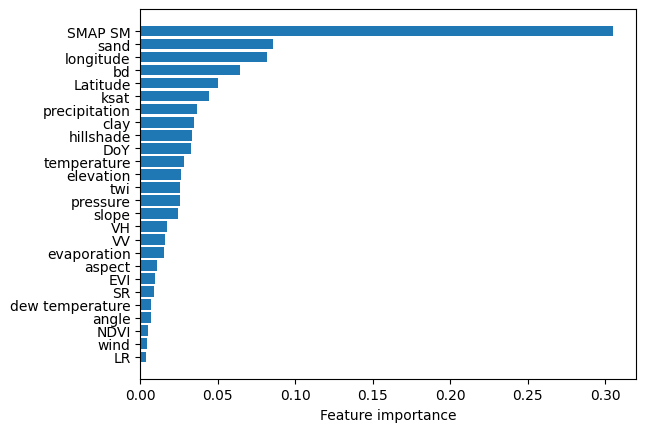

In [ ]:

# @title Calculate feature importance
import matplotlib.pyplot as plt

ML1_feature_names = ['DoY', 'longitude','Latitude','hillshade','slope','aspect','elevation',
                     'twi','sand','clay','bd','ksat','EVI','NDVI','VV','VH',
                     'angle','SMAP SM', 'precipitation', 'evaporation', 'SR',
                     'LR', 'wind', 'temperature', 'dew temperature', 'pressure']
ML2_feature_names = ['DoY', 'longitude', 'Latitude','hillshade','slope','aspect','elevation',
                     'twi','sand','clay','bd','ksat','EVI','B2','B3','B4','B5',
                     'B6','B7','B8','B8A','B11','B12','NDVI','NDWI','greenness',
                     'brightness','wetness','SMAP SM', 'precipitation', 'evaporation',
                     'SR', 'LR', 'wind', 'temperature', 'dew temperature', 'pressure']

ML3_feature_names = ['DoY', 'longitude', 'Latitude','hillshade','slope','aspect','elevation',
                     'twi','sand','clay','bd','ksat','EVI','B2','B3','B4','B5',
                     'B6','B7','B10','B11','NDVI','NDWI','greenness',
                     'brightness','wetness','SMAP SM', 'precipitation', 'evaporation',
                     'SR', 'LR', 'wind', 'temperature', 'dew temperature', 'pressure']

sorted_idx = ML1_sly_xgbq_mean.feature_importances_.argsort()
feature_names_sorted = [ML1_feature_names[int(i)] for i in sorted_idx]
plt.barh(feature_names_sorted, ML1_sly_xgbq_mean.feature_importances_[sorted_idx])
plt.xlabel("Feature importance")

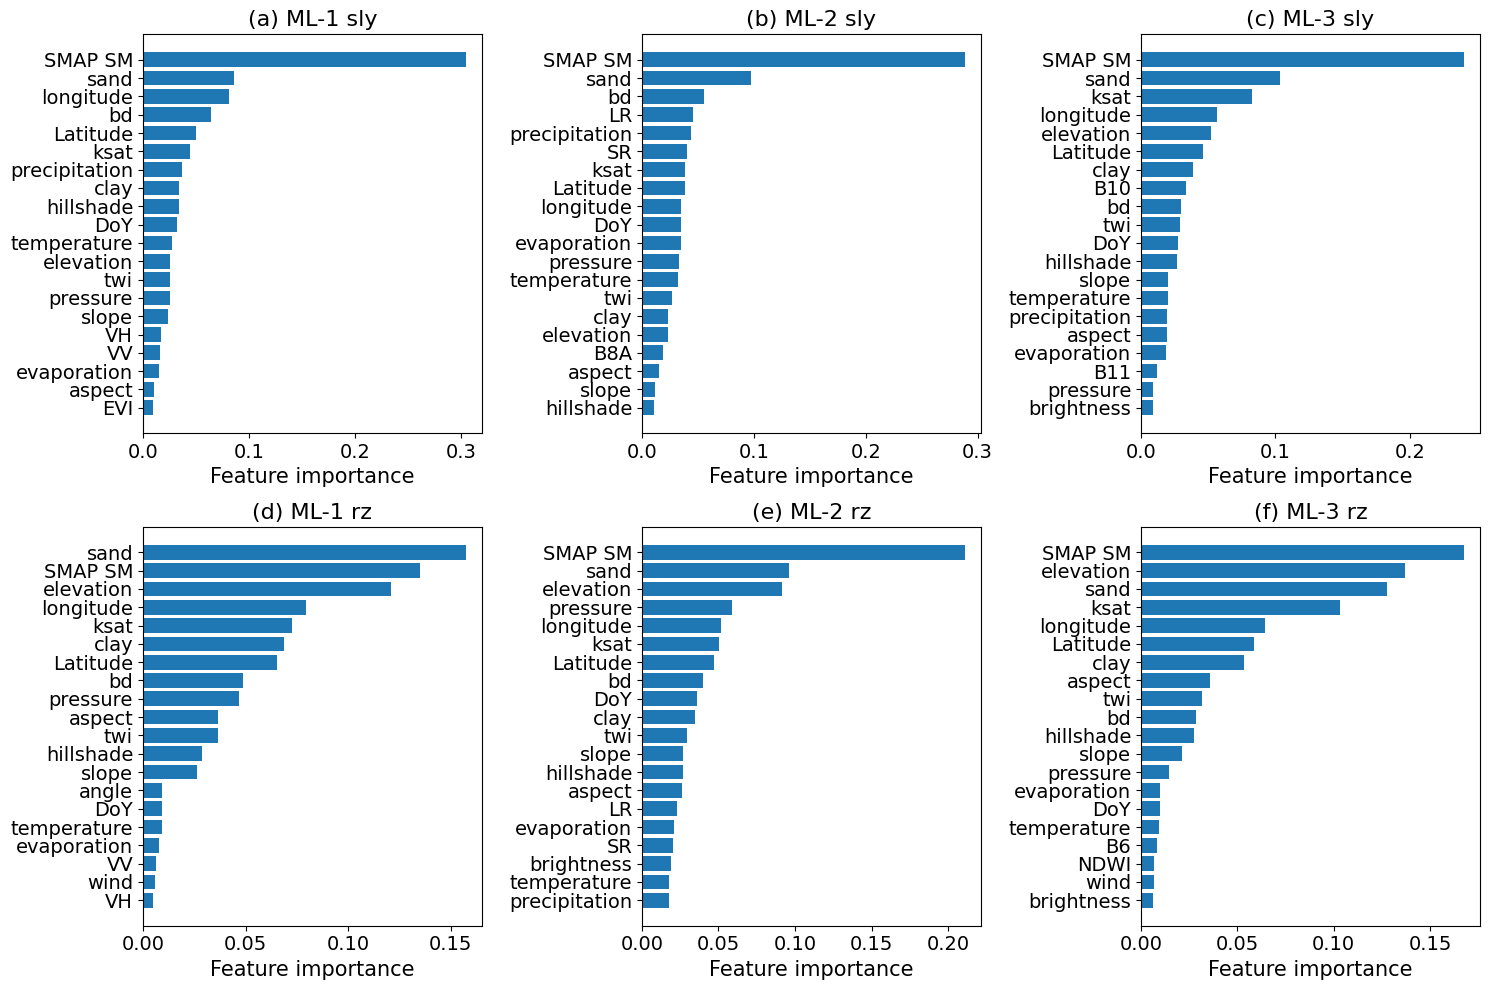

In [ ]:
# Define the models and their feature names
models = [ML1_sly_xgbq_mean, ML2_sly_xgbq_mean, ML3_sly_xgbq_mean,
          ML1_rly_xgbq_mean, ML2_rly_xgbq_mean, ML3_rly_xgbq_mean]

feature_names = [ML1_feature_names, ML2_feature_names, ML3_feature_names,
                 ML1_feature_names, ML2_feature_names, ML3_feature_names]

titles = ['(a) ML-1 sly', '(b) ML-2 sly', '(c) ML-3 sly',
          '(d) ML-1 rz', '(e) ML-2 rz', '(f) ML-3 rz']

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily iterate

# Loop through models and axes to create the feature importance plots
for i, (model, features, title, ax) in enumerate(zip(models, feature_names, titles, axes)):
    sorted_idx = model.feature_importances_.argsort()[-20:]  # Get indices of top 20 features
    feature_names_sorted = [features[int(idx)] for idx in sorted_idx]  # Sort the feature names
    ax.barh(feature_names_sorted, model.feature_importances_[sorted_idx])  # Horizontal bar plot
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Feature importance", fontsize=15)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.savefig('feature_importance.jpeg', dpi=600)
plt.show()

## Run EnKF to integrate ML estimates into a process model, Layered Green and Ampt infitration with Redistribution

Note that since LGRA model is coded in c/c++, here, the code only includes the data preparing.

### Reorgnize ML results - perform full CDF matching

In [ ]:
from scipy.stats import rankdata

def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    return ranks / len(data)  # Normalize by the number of points

def cdf_matching(source, target):
    sorted_target = np.sort(target)  # Target distribution sorted
    sorted_target_ranks = rankdata(sorted_target, method='average')
    sorted_target_quantiles = sorted_target_ranks / len(sorted_target)
    ranks = rankdata(source, method='average')  # Source data ranks
    percentiles = ranks / len(source)  # Percentile positions of source data
    matched_values = np.interp(percentiles, sorted_target_quantiles, sorted_target)  # Interpolation
    return matched_values


def correct_2_ML3(Sentinel_sl_arr, sentinel2_sl_arr, hls_sl_arr, Sentinel_rly_arr, sentinel2_rly_arr, hls_rly_arr):
    Sentinel_sl_arr_ = Sentinel_sl_arr.copy()
    sentinel2_sl_arr_ = sentinel2_sl_arr.copy()
    hls_sl_arr_ = hls_sl_arr.copy()
    Sentinel_rly_arr_ = Sentinel_rly_arr.copy()
    sentinel2_rly_arr_ = sentinel2_rly_arr.copy()
    hls_rly_arr_ = hls_rly_arr.copy()
    # Xid_all, Xyear_all, Xdoy_all, Xutc_all, y_hat, y_up_hat, y_median_hat, y_low_hat
    # surface layer
    ids = list(set(sentinel2_sl_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_sl_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_sl_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_sl_arr_[:, 0] == idd

        Sentinel_sl_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_sl_arr_[Sentinel_mask, 4], hls_sl_arr_[hls_mask, 4])
        sentinel2_sl_arr_[sentinel2_mask, 4] = cdf_matching(sentinel2_sl_arr_[sentinel2_mask, 4], hls_sl_arr_[hls_mask, 4])


    # rootzone
    ids = list(set(sentinel2_rly_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_rly_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_rly_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_rly_arr_[:, 0] == idd

        Sentinel_rly_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_rly_arr_[Sentinel_mask, 4], hls_rly_arr_[hls_mask, 4])
        sentinel2_rly_arr_[sentinel2_mask, 4] = cdf_matching(sentinel2_rly_arr_[sentinel2_mask, 4], hls_rly_arr_[hls_mask, 4])

    return Sentinel_sl_arr_, sentinel2_sl_arr_, hls_sl_arr_, Sentinel_rly_arr_, sentinel2_rly_arr_, hls_rly_arr_

def calculate_sd_and_miu(ML1_sl_arr, ML2_sl_arr, ML3_sl_arr, ML1_rly_arr, ML2_rly_arr, ML3_rly_arr):
    # Xid_all, Xyear_all, Xdoy_all, Xutc_all, y_hat

    # soil moisture
    hls_sl_arr = ML1_sl_arr.copy()
    temp_arr = np.zeros((hls_sl_arr.shape[0], 6)) + 3
    temp_arr[:, 0:5] = hls_sl_arr[:, 0:5]
    hls_sl_arr = temp_arr.copy()

    Sentinel_sl_arr = ML2_sl_arr.copy()
    temp_arr = np.zeros((Sentinel_sl_arr.shape[0], 6)) + 1
    temp_arr[:, 0:5] = Sentinel_sl_arr[:, 0:5]
    Sentinel_sl_arr = temp_arr.copy()

    sentinel2_sl_arr = ML3_sl_arr.copy()
    temp_arr = np.zeros((sentinel2_sl_arr.shape[0], 6)) + 2
    temp_arr[:, 0:5] = sentinel2_sl_arr[:, 0:5]
    sentinel2_sl_arr = temp_arr.copy()

    ssm_sl_arr = np.vstack((hls_sl_arr, Sentinel_sl_arr, sentinel2_sl_arr))
    ssm_sl_arr_0 = ssm_sl_arr.copy()
    ssm_sl_arr_0[:, 3] += -1
    ssm_sl_arr_1 = ssm_sl_arr.copy()
    ssm_sl_arr_1[:, 3] += 1
    ssm_sl_arr = np.vstack((ssm_sl_arr_0, ssm_sl_arr, ssm_sl_arr_1)).copy()

    # soil moisture standard deviation
    # The ubRMSE is also referred to as the standard deviation of the error
    hls_sl_arr = ML1_sl_arr.copy()
    temp_arr = np.zeros((hls_sl_arr.shape[0], 6)) + 3
    temp_arr[:, 0:4] = hls_sl_arr[:, 0:4]
    temp_arr[:, 4] = (hls_sl_arr[:, 5] - hls_sl_arr[:, 7])/3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    hls_sl_arr = temp_arr.copy()

    Sentinel_sl_arr = ML2_sl_arr.copy()
    temp_arr = np.zeros((Sentinel_sl_arr.shape[0], 6)) + 1
    temp_arr[:, 0:4] = Sentinel_sl_arr[:, 0:4]
    temp_arr[:, 4] = (Sentinel_sl_arr[:, 5] - Sentinel_sl_arr[:, 7]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    Sentinel_sl_arr = temp_arr.copy()

    sentinel2_sl_arr = ML3_sl_arr.copy()
    temp_arr = np.zeros((sentinel2_sl_arr.shape[0], 6)) + 2
    temp_arr[:, 0:4] = sentinel2_sl_arr[:, 0:4]
    temp_arr[:, 4] = (sentinel2_sl_arr[:, 5] - sentinel2_sl_arr[:, 7]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    sentinel2_sl_arr = temp_arr.copy()

    sd_sl_arr = np.vstack((hls_sl_arr, Sentinel_sl_arr, sentinel2_sl_arr))
    sd_sl_arr_0 = sd_sl_arr.copy()
    sd_sl_arr_0[:, 3] += -1
    sd_sl_arr_1 = sd_sl_arr.copy()
    sd_sl_arr_1[:, 3] += 1
    sd_sl_arr = np.vstack((sd_sl_arr_0, sd_sl_arr, sd_sl_arr_1)).copy()


    ids = list(set(ssm_sl_arr[:, 0]))
    temp_arr = np.zeros((len(ids), 2))
    for i in range(len(ids)):
        temp_arr[i, 0] = ids[i]
        mask = ssm_sl_arr[:, 0] == ids[i]
        temp_arr[i, 1] = np.mean(ssm_sl_arr[mask, 4])
    miu_sl_arr = temp_arr.copy()

    # rootzone
    hls_rly_arr = ML1_rly_arr.copy()
    temp_arr = np.zeros((hls_rly_arr.shape[0], 6)) + 3
    temp_arr[:, 0:5] = hls_rly_arr[:, 0:5]
    hls_rly_arr = temp_arr.copy()

    Sentinel_rly_arr = ML2_rly_arr.copy()
    temp_arr = np.zeros((Sentinel_rly_arr.shape[0], 6)) + 1
    temp_arr[:, 0:5] = Sentinel_rly_arr[:, 0:5]
    Sentinel_rly_arr = temp_arr.copy()

    sentinel2_rly_arr = ML3_rly_arr.copy()
    temp_arr = np.zeros((sentinel2_rly_arr.shape[0], 6)) + 2
    temp_arr[:, 0:5] = sentinel2_rly_arr[:, 0:5]
    sentinel2_rly_arr = temp_arr.copy()


    ssm_rly_arr = np.vstack((hls_rly_arr, Sentinel_rly_arr, sentinel2_rly_arr))
    ssm_rly_arr_0 = ssm_rly_arr.copy()
    ssm_rly_arr_0[:, 3] += -1
    ssm_rly_arr_1 = ssm_rly_arr.copy()
    ssm_rly_arr_1[:, 3] += 1
    ssm_rly_arr = np.vstack((ssm_rly_arr_0, ssm_rly_arr, ssm_rly_arr_1)).copy()

    # The ubRMSE is also referred to as the standard deviation of the error
    hls_rly_arr = ML1_rly_arr.copy()
    temp_arr = np.zeros((hls_rly_arr.shape[0], 6)) + 3
    temp_arr[:, 0:4] = hls_rly_arr[:, 0:4]
    temp_arr[:, 4] = (hls_rly_arr[:, 5] - hls_rly_arr[:, 7]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    hls_rly_arr = temp_arr.copy()

    Sentinel_rly_arr = ML2_rly_arr.copy()
    temp_arr = np.zeros((Sentinel_rly_arr.shape[0], 6)) + 1
    temp_arr[:, 0:4] = Sentinel_rly_arr[:, 0:4]
    temp_arr[:, 4] = (Sentinel_rly_arr[:, 5] - Sentinel_rly_arr[:, 7]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    Sentinel_rly_arr = temp_arr.copy()

    sentinel2_rly_arr = ML3_rly_arr.copy()
    temp_arr = np.zeros((sentinel2_rly_arr.shape[0], 6)) + 2
    temp_arr[:, 0:4] = sentinel2_rly_arr[:, 0:4]
    temp_arr[:, 4] = (sentinel2_rly_arr[:, 5] - sentinel2_rly_arr[:, 7]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    sentinel2_rly_arr = temp_arr.copy()

    sd_rly_arr = np.vstack((hls_rly_arr, Sentinel_rly_arr, sentinel2_rly_arr))
    sd_rly_arr_0 = sd_rly_arr.copy()
    sd_rly_arr_0[:, 3] += -1
    sd_rly_arr_1 = sd_rly_arr.copy()
    sd_rly_arr_1[:, 3] += 1
    sd_rly_arr = np.vstack((sd_rly_arr_0, sd_rly_arr, sd_rly_arr_1)).copy()


    ids = list(set(ssm_rly_arr[:, 0]))
    temp_arr = np.zeros((len(ids), 2))
    for i in range(len(ids)):
        temp_arr[i, 0] = ids[i]
        mask = ssm_rly_arr[:, 0] == ids[i]
        temp_arr[i, 1] = np.mean(ssm_rly_arr[mask, 4])
    miu_rly_arr = temp_arr.copy()

    return ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr



def create_date_list(start_date_str, num, deltat, unit='d'):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

    date_list = []
    for i in range(num):
        date_list.append(start_date)
        if unit == 'd':
            start_date += timedelta(days=deltat)
        elif unit == 'h':
            start_date += timedelta(hours=deltat)

    return date_list


def DoY2Date(year, doy, hh=10):
    base_date = datetime(year, 1, 1, hour=hh)
    target_date = base_date + timedelta(days=(doy - 1))
    return target_date


def reorgnize_2_2d(ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr, refer_id_arr):
    ids = refer_id_arr
    len_seq = 61344
    len_id = len(ids)

    # ----------------------------
    datelist = create_date_list('2016-01-01', len_seq, 1, unit='h')
    df_date = pd.DataFrame({'time': datelist})
    df_date.set_index('time', inplace=True)

    # surface layer - sm
    df_ssm_sly = pd.DataFrame(ssm_sl_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_ssm_sly = df_ssm_sly[(df_ssm_sly['hour'] >= 0) & (df_ssm_sly['hour'] <= 23)]
    df_ssm_sly['time'] = df_ssm_sly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])), axis=1)

    ssm_sl_arr3D = np.zeros((3, len_seq, len_id))
    ssm_sl_arr3D[:] = np.nan
    sors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_ssm_sly_sor_id = df_ssm_sly[(df_ssm_sly['sensor']==sor)&(df_ssm_sly['id']==iid)]
            df_ssm_sly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_ssm_sly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            ssm_sl_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # rootzone - sm
    df_ssm_rly = pd.DataFrame(ssm_rly_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_ssm_rly = df_ssm_rly[(df_ssm_rly['hour'] >= 0) & (df_ssm_rly['hour'] <= 23)]
    df_ssm_rly['time'] = df_ssm_rly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    ssm_rly_arr3D = np.zeros((3, len_seq, len_id))
    ssm_rly_arr3D[:] = np.nan
    sors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]

            df_ssm_rly_sor_id = df_ssm_rly[(df_ssm_rly['sensor']==sor)&(df_ssm_rly['id']==iid)]
            df_ssm_rly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_ssm_rly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            ssm_rly_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # surface layer - SD
    df_sd_sly = pd.DataFrame(sd_sl_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_sd_sly = df_sd_sly[(df_sd_sly['hour'] >= 0) & (df_sd_sly['hour'] <= 23)]
    df_sd_sly['time'] = df_sd_sly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    sd_sl_arr3D = np.zeros((3, len_seq, len_id))
    sd_sl_arr3D[:] = np.nan

    fsors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_sd_sly_sor_id = df_sd_sly[(df_sd_sly['sensor'] == sor) & (df_sd_sly['id'] == iid)]
            df_sd_sly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_sd_sly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            sd_sl_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # rootzone - sd
    df_sd_rly = pd.DataFrame(sd_rly_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_sd_rly = df_sd_rly[(df_sd_rly['hour'] >= 0) & (df_sd_rly['hour'] <= 23)]
    df_sd_rly['time'] = df_sd_rly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    sd_rly_arr3D = np.zeros((3, len_seq, len_id))
    sd_rly_arr3D[:] = np.nan
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_sd_rly_sor_id = df_sd_rly[(df_sd_rly['sensor'] == sor) & (df_sd_rly['id'] == iid)]
            df_sd_rly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_sd_rly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            sd_rly_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]

    # ======================================

    miu_sl_arr1D = np.zeros((len(ids)))
    miu_sl_arr1D[:] = np.nan
    for j in range(len(ids)):
        iid = ids[j]
        if len(miu_sl_arr[miu_sl_arr[:, 0]==iid, 1]) == 0:
            miu_sl_arr1D[j] = np.nan
            continue
        meanvalue = miu_sl_arr[miu_sl_arr[:, 0]==iid, 1][0]
        miu_sl_arr1D[j] = meanvalue

    miu_rly_arr1D = np.zeros((len(ids)))
    miu_rly_arr1D[:] = np.nan
    for j in range(len(ids)):
        iid = ids[j]
        if len(miu_rly_arr[miu_rly_arr[:, 0] == iid, 1]) == 0:
            miu_rly_arr1D[j] = np.nan
            continue
        meanvalue = miu_rly_arr[miu_rly_arr[:, 0] == iid, 1][0]
        miu_rly_arr1D[j] = meanvalue


    ssm_sl_arr2D = np.nanmean(ssm_sl_arr3D, axis=0)
    ssm_rly_arr2D = np.nanmean(ssm_rly_arr3D, axis=0)
    sd_sl_arr2D = np.nanmean(sd_sl_arr3D, axis=0)
    sd_rly_arr2D = np.nanmean(sd_rly_arr3D, axis=0)

    return ssm_sl_arr2D, ssm_rly_arr2D, sd_sl_arr2D, sd_rly_arr2D, miu_sl_arr1D, miu_rly_arr1D


In [ ]:
# @title Run functions
ML1_sl_arr_corrected, ML2_sl_arr_corrected, ML3_sl_arr_corrected, \
ML1_rly_arr_corrected, ML2_rly_arr_corrected, ML3_rly_arr_corrected = correct_2_ML3(ML1_sly_y_pred_all_arr,
                                                                                    ML2_sly_y_pred_all_arr,
                                                                                    ML3_sly_y_pred_all_arr,
                                                                                    ML1_rly_y_pred_all_arr,
                                                                                    ML2_rly_y_pred_all_arr,
                                                                                    ML3_rly_y_pred_all_arr)

ssm_sl_arr, ssm_rly_arr, sd_sl_arr, \
sd_rly_arr, miu_sl_arr, miu_rly_arr = calculate_sd_and_miu(ML1_sl_arr_corrected,
                                                          ML2_sl_arr_corrected,
                                                          ML3_sl_arr_corrected,
                                                          ML1_rly_arr_corrected,
                                                          ML2_rly_arr_corrected,
                                                          ML3_rly_arr_corrected)

ssm_sl_arr2D, ssm_rly_arr2D, sd_sl_arr2D, \
sd_rly_arr2D, miu_sl_arr1D, miu_rly_arr1D = reorgnize_2_2d(ssm_sl_arr,
                                                           ssm_rly_arr,
                                                           sd_sl_arr,
                                                           sd_rly_arr,
                                                           miu_sl_arr,
                                                           miu_rly_arr,
                                                           refer_id_arr)

del ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr

<ipython-input-87-5fc8a5db3252>:314: RuntimeWarning: Mean of empty slice
  ssm_sl_arr2D = np.nanmean(ssm_sl_arr3D, axis=0)
<ipython-input-87-5fc8a5db3252>:315: RuntimeWarning: Mean of empty slice
  ssm_rly_arr2D = np.nanmean(ssm_rly_arr3D, axis=0)
<ipython-input-87-5fc8a5db3252>:316: RuntimeWarning: Mean of empty slice
  sd_sl_arr2D = np.nanmean(sd_sl_arr3D, axis=0)
<ipython-input-87-5fc8a5db3252>:317: RuntimeWarning: Mean of empty slice
  sd_rly_arr2D = np.nanmean(sd_rly_arr3D, axis=0)
